<a href="https://colab.research.google.com/github/soyheo/Project_public/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project 2**

목적 : 중고차의 경쟁력 있는 가격대 결정 방법

배경지식:

가설:


1.   캐나다에서 인기있는 메이커의 중고차 가격이 상대적으로 높을 것이며, 메이커별 중고차 가격 결정이 유의미할 것이다
2.   캐나다의 대도시(토론토, 밴쿠버, 몬트리올, 백그라운드 조사 결과)의 중고차 가격대가 상대적으로 높을 것이며, 도시별 가격 설정을 다르게 해야 할 것이다
3.   차량의 주행거리가 출시연도보다 가격에 더 큰 영향을 가질 것이다 


In [206]:
'''
!pip install category_encoders==2.*
!pip install eli5
# !pip install pandas-profiling==2.*
!pip install pdpbox
!pip install --upgrade xgboost
'''

'\n!pip install category_encoders==2.*\n!pip install eli5\n# !pip install pandas-profiling==2.*\n!pip install pdpbox\n!pip install --upgrade xgboost\n'

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# import any libraries needed
# YOUR CODE HERE
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from scipy.stats import randint, uniform

1. id: This is a GUID and unique in the feed.
2. vin: 17 char long VIN of the car, unique values
3. price: The car price as listed on the website
4. miles: The car miles/odometer as listed on the website
5. stock_no: Stock number of the car listed on the website
6. year: Model Year of the car (VIN Decoded)
7. make: Make of the car (VIN Decoded)
8. model: Model of the car (VIN Decoded)
9. trim: Trim of the car (VIN Decoded)
10. body_type: Body type of the car (VIN Decoded)
11. vehicle_type: Vehicle type of the car (VIN Decoded)
12. drivetrain: Drivetrain of the car (VIN Decoded)
13. transmission: Transmission of the car (VIN Decoded)
14. fuel_type: Fuel type of the car (VIN Decoded)
15. engine_size: Engine size of the car (VIN Decoded)
16. engine_block: Engine block of the car (VIN Decoded)
17. seller_name: Dealer Name
18. street: Dealer address street
19. city: Dealer address city
20. state: Dealer address state
21. zip: Dealer address zip

In [208]:
df = pd.read_csv("ca-dealers-used.csv")
# df_dic = pd.read_excel("cars_data_dictionary.xlsx")
df.head()

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4
3,b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2
4,ac40c9fc-0676,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,acura pickering,575 Kingston Road,Pickering,ON,L1V 3N7


**1. 데이터 정제**

In [209]:
df.year.unique()

array([2017., 2020., 2008., 2011., 2012., 2002., 2005., 2004., 2003.,
       2018., 2007., 2001., 2019., 2015., 2013., 2014., 2016., 2000.,
       1999., 1997., 1998., 2009., 2010., 2021., 2006., 1996., 1993.,
       1988., 1995., 1994., 1989., 1985.,   nan, 1992., 1981., 1984.,
       1987., 1990., 1986., 1983., 1991., 1982., 2022.])

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393603 entries, 0 to 393602
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            393603 non-null  object 
 1   vin           393603 non-null  object 
 2   price         358486 non-null  float64
 3   miles         366590 non-null  float64
 4   stock_no      365929 non-null  object 
 5   year          393586 non-null  float64
 6   make          393603 non-null  object 
 7   model         388809 non-null  object 
 8   trim          354824 non-null  object 
 9   body_type     359578 non-null  object 
 10  vehicle_type  355365 non-null  object 
 11  drivetrain    354608 non-null  object 
 12  transmission  357922 non-null  object 
 13  fuel_type     322790 non-null  object 
 14  engine_size   320950 non-null  float64
 15  engine_block  320439 non-null  object 
 16  seller_name   391371 non-null  object 
 17  street        385674 non-null  object 
 18  city

In [211]:
# 결측값 확인
df.isnull().sum()

id                  0
vin                 0
price           35117
miles           27013
stock_no        27674
year               17
make                0
model            4794
trim            38779
body_type       34025
vehicle_type    38238
drivetrain      38995
transmission    35681
fuel_type       70813
engine_size     72653
engine_block    73164
seller_name      2232
street           7929
city             7774
state            7836
zip              7769
dtype: int64

In [212]:
df[df['miles'].isnull()]
# df[df == np.nan]

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
24,6a88647d-ff1a,1C3BC8EG0BN617610,10995.0,NaN,11024-21,2011.0,Chrysler,200,S,Convertible,...,FWD,Automatic,E85,3.6,V,western auto sales,302 Algonquin Boulevard West,Timmins,ON,P4N 2S1
43,3d408594-354a,1FMZU74E22ZC78774,4990.0,NaN,ST1F8774,2002.0,Ford,Explorer,Eddie Bauer,SUV,...,4WD,Automatic,Unleaded / E85,4.0,V,caprice auto centre,240 12th Street,New Westminster,BC,V3M 4H2
73,8abd92bf-e859,1FTEW1E50JKC29959,39995.0,NaN,21-0407A,2018.0,Ford,F-150,XLT,Pickup,...,4WD,Automatic,Unleaded / Unleaded,5.0,V,ledingham chevrolet buick gmc,200 Manitoba 12,Steinbach,MB,R5G 1T6
103,bfc18879-7a51,1FTEW1E52JFE30500,44649.0,NaN,NaN,2018.0,Ford,F-150,XLT,Pickup,...,4WD,Automatic,Unleaded / Unleaded,5.0,V,elgin chrysler jeep dodge ram,275 Wellington Street St. Thomas,St Thomas,ON,N5R 2S6
113,9a07a241-5788,1FTEW1E52JFE30500,44649.0,NaN,NaN,2018.0,Ford,F-150,XLT,Pickup,...,4WD,Automatic,Unleaded / Unleaded,5.0,V,autoiq,395 Dunlop Street West,Barrie,ON,L4N 1C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393498,aae11989-1668,KNDCE3LC3H5095173,NaN,NaN,07206A,2017.0,Kia,Niro,Touring,Hatchback,...,FWD,Manual,Electric / Unleaded,1.6,I,kia west,1881 United Boulevard,Coquitlam,BC,V3K 0B6
393499,cf33494c-b2f7,KNDCE3LC3H5095173,NaN,NaN,07206A,2017.0,Kia,Niro,Touring,Hatchback,...,FWD,Manual,Electric / Unleaded,1.6,I,west auto sales group,161 Marsh Drive,Quesnel,BC,V2J 1E7
393500,f1300ef8-87cf,KNDCE3LC3H5095173,NaN,NaN,07206A,2017.0,Kia,Niro,Touring,Hatchback,...,FWD,Manual,Electric / Unleaded,1.6,I,cariboo truck & auto sales,161 Marsh Drive,Quesnel,BC,V2J 1E8
393514,79462148-6143,KNDCE3LC6J5168980,NaN,NaN,NaN,2018.0,Kia,Niro,Touring,Hatchback,...,FWD,Automatic,Electric / Unleaded,1.6,I,davewall.ca,19820 Fraser Highway,Langley City,BC,V3A 4C9


In [213]:
# vin 중복치 확인인
df.vin.duplicated().sum()

166912

In [214]:
# 결측값 삭제
df = df.dropna().reset_index(drop=True) # 데이터가 충분해 결측치는 삭제한다다

# 중복값 삭제
df.vin.duplicated().sum()
df = df.drop_duplicates(subset=['vin'], ignore_index=True) # 데이터 특성상 vin의 히스토리가 모두 나오므로 가장 최신의 데이터를 기준으로 분석석


In [215]:
# 데이터타입 변경
df['year']= df['year'].astype("int")
df.year

0         2017
1         2017
2         2017
3         2020
4         2017
          ... 
150949    2018
150950    2018
150951    2019
150952    2018
150953    2020
Name: year, Length: 150954, dtype: int64

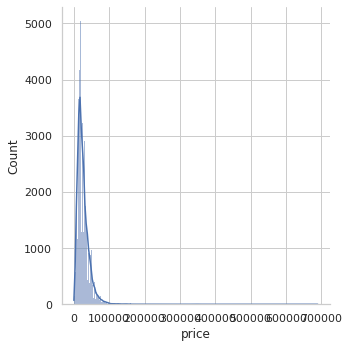

In [216]:
## 수치형 데이터의 분포 확인인 ##
# 타겟(price)의 분포 확인(right-skewed)
sns.displot(df['price'], kde=True);

In [217]:
# price가 0인 데이터 확인인
df[df['price']==0]
# 이상치로로 확인

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
1386,073a292c-6789,WBY2Z6C06L7F42570,0.0,90.0,I606824,2020,BMW,I8,Base,Targa,...,4WD,Automatic,Electric / Premium Unleaded,1.5,I,budds' bmw,2454 South Service Road West,Oakville,ON,L6L 5M9
31931,36e9312a-a3f2,2FMPK4J85GBC54229,0.0,65125.0,2FMPK4,2016,Ford,Edge,SEL,SUV,...,4WD,Automatic,Unleaded,3.5,V,degroote-hill chevrolet buick gmc,270 Highway #3 East,Tillsonburg,ON,N4G 4H3
99595,4892dbb0-cf02,KMHD84LF8JU596465,0.0,0.0,H3431,2018,Hyundai,Elantra,Limited,Sedan,...,FWD,Automatic,Unleaded,2.0,I,gyro mazda,134 Laird Drive East York,Toronto,ON,M4G 3V7
115004,11de6ae5-5b7b,2C4RDGBG8LR251762,0.0,22.0,LGC1762,2020,Dodge,Grand Caravan,SE,Minivan,...,FWD,Automatic,E85 / Unleaded,3.6,V,derrick dodge,6211 104 Street Northwest,Edmonton,AB,T6H 2K8
119393,68b16f5f-81ae,1C4RJFDJ8LC414169,0.0,35806.0,44769AU,2020,Jeep,Grand Cherokee,SRT,SUV,...,4WD,Automatic,Premium Unleaded,6.4,V,welland toyota,894 Niagara Street,Welland,ON,L3C 1M3
124333,a2a267f4-914b,3GTU2PEJ9JG285249,0.0,11382.0,21T151A,2018,GMC,Sierra 1500 Denali,Denali,Pickup,...,4WD,Automatic,Premium Unleaded,6.2,V,westlock motors,10415 104 Avenue,Westlock,AB,T7P 2E4


In [218]:
# price가 100000이상인 데이터 확인인
df[df['price'] > 100000]
# 100000불 이상의 target이 극소수지만 럭셔리 카의 케이스로 확인(이상치로 판단하지 않는다)

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4
3,b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2
4,0487af07-893c,19UNC1B03HY800063,155771.0,18281.0,U02856,2017,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,gravel auto crdit,102-1007 Boulevard Ren Lvesque Verdun,Montral,QC,H3E 0H1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148011,54d61ef9-53a9,ZPBUA1ZL9LLA08112,269000.0,21198.0,904636,2020,Lamborghini,Urus,Base,SUV,...,4WD,Automatic,Premium Unleaded,4.0,V,hgrgoire,625 Rue Dubois,Saint-eustache,QC,J7P 3W1
148012,75485435-0109,ZPBUA1ZLXKLA03998,259000.0,10287.0,904888,2019,Lamborghini,Urus,Base,SUV,...,4WD,Automatic,Premium Unleaded,4.0,V,hgrgoire,625 Rue Dubois,Saint-eustache,QC,J7P 3W1
149002,4c9c3f8f-f6d3,4JGFB5KB8MA310456,100177.0,90.0,21028102,2021,Mercedes-Benz,GLE,GLE450,SUV,...,4WD,Automatic,Electric / Unleaded,3.0,I,mercedes-benz north vancouver,1375 Marine Drive,North Vancouver,BC,V7P 3E5
150923,1b392ca8-b5c8,W1KUG7DB1LA529608,120790.0,4995.0,220351,2020,Mercedes-Benz,S-Class,S560e,Sedan,...,RWD,Automatic,Electric / Unleaded,3.0,V,mercedes-benz sherbrooke,"4787, Boul. Bourque",Sherbrooke,QC,J1N 2G6


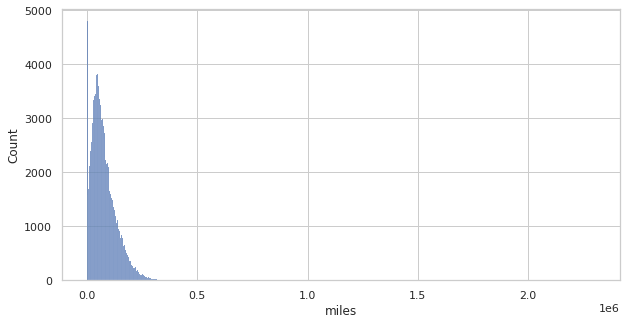

In [219]:
# miles 의 전체 분포
sns.histplot(df.miles);

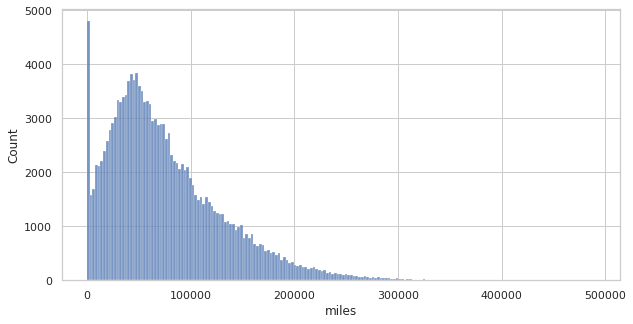

In [220]:
# miles < 500000 분포
sort = df[df.miles < 500000]
sns.histplot(sort.miles);

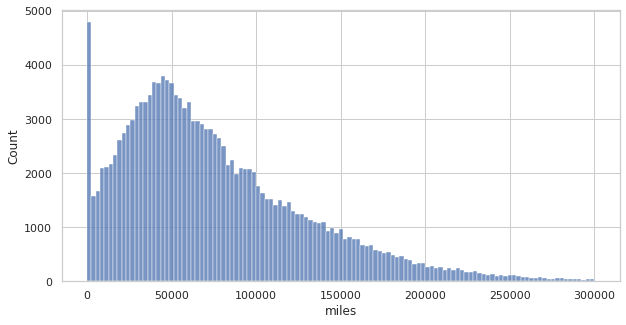

In [221]:
sort = df[df.miles < 300000]
sns.histplot(sort.miles);

In [222]:
# df.sort_values(by='miles', ascending=True).head(100)
# sns.histplot(df[(df.miles < 50)].miles)

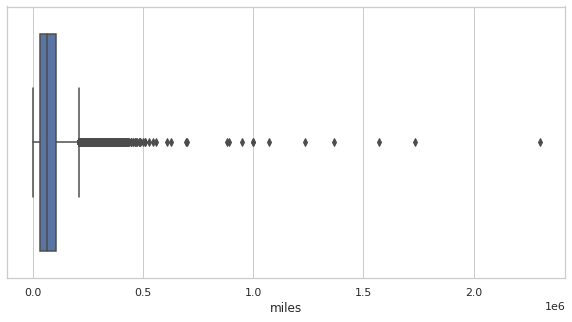

In [223]:
# miles 전체 분포 box plot
sns.boxplot(x = "miles",  data = df);

In [224]:
# miles가 300000이상인 데이터의 갯수가 0.2%로 이상치로 판단하고 제거한다
len(df[df.miles > 300000]) / len(df)


0.00244445327715728

0.02359659233938816


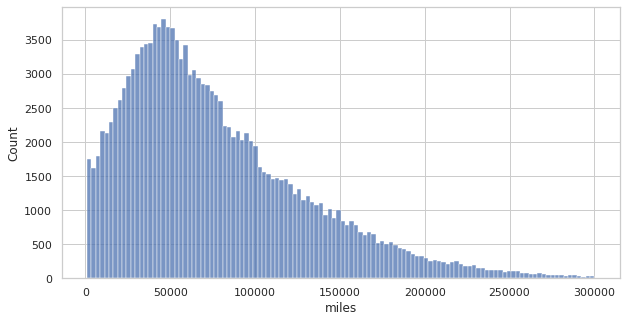

In [225]:
# 앞선 히스토그램에서 0마일에 가까운(거의 신차나 다름없는) 데이터의 수가 특별히 많으므로 2% 정도를 차지하는 1000미만 마일 데이터는 제거한다
print(len(df[df.miles < 1000]) / len(df))
sort = df[(df.miles < 300000) & (df.miles > 1000)]
sns.histplot(sort.miles);

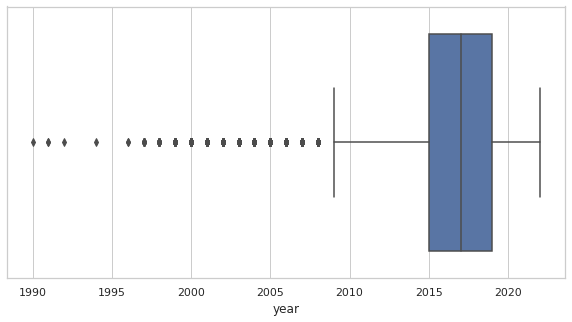

In [226]:
# year 전체분포 확인
sns.boxplot(x = "year",  data = df);

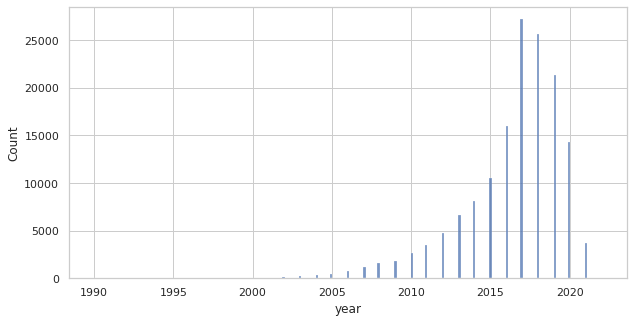

In [227]:
sns.histplot(df.year);

In [228]:
len(df[df.year < 2007]) / len(df)
# 2007년형 이전 출시된 차의 데이터가 전체 분포 대비 매우 적은 수준으로 데이터의 왜곡이 있을 수 있으므로 삭제하고 2009년 이후 출시된 자동차만을 대상으로 분석한다

0.01355379784570134

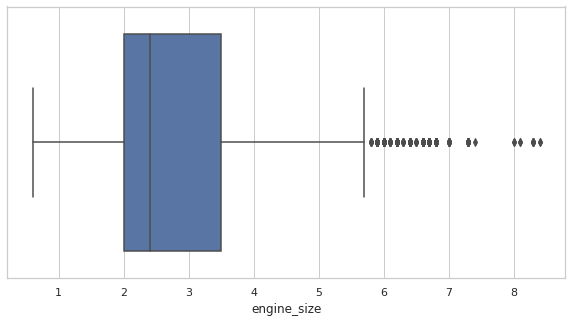

In [229]:
# engine_size 분포 확인인
# sns.histplot(df.engine_size);
sns.boxplot(x = "engine_size",  data = df);

In [230]:
len(df[df.engine_size>5.7]) / len(df)

0.02636564781324112

In [231]:
df[df.engine_size>5.7]
# 주로 픽업트럭이나 승객용 밴으로 이상치로 판단하지 않는다다

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
583,122b168b-003b,1GAWGFFBXL1125936,49900.0,21861.0,A125936,2020,Chevrolet,Express Passenger,LT,Passenger Van,...,RWD,Automatic,Compressed Natural Gas / Lpg,6.0,V,mcgee motors ltd,180 Suncoast Drive East,Goderich,ON,N7A 4N4
584,d7007f7a-10e9,1GAZGNFB0J1263103,31999.0,124532.0,J1263103,2018,Chevrolet,Express Passenger,LS,Passenger Van,...,RWD,Automatic,Compressed Natural Gas / Lpg,6.0,V,gmm auto sales,17 Tangiers Road North York,Toronto,ON,M3J 2B1
585,0a5ecad3-aa7d,1GC1KVEB7FF150084,27999.0,201297.0,FF150084,2015,Chevrolet,Silverado 2500HD,LT,Pickup,...,4WD,Automatic,Compressed Natural Gas / Unleaded,6.0,V,gmm auto sales,17 Tangiers Road North York,Toronto,ON,M3J 2B1
586,1a66c20f-73f4,1GCHK23618F122755,19980.0,486471.0,Z-212S5663A,2008,Chevrolet,Silverado 2500HD,LTZ,Pickup,...,4WD,Automatic,Biodiesel,6.6,V,brightdrive,9210 34 Ave Nw,Edmonton,AB,T6E 5P2
587,62ac577a-94ef,1GCHK23657F511638,23995.0,257778.0,XXXX,2007,Chevrolet,Silverado 2500HD,LTZ,Pickup,...,4WD,Automatic,Biodiesel,6.6,V,tiger auto sales ltd.,2275 Dundas St. East,Unit A,ON,N5V 1R4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148957,d311b131-7c4b,3GCUCUEJ1BG176121,10500.0,211000.0,4324,2011,Chevrolet,Silverado 1500,2HY,Pickup,...,RWD,Automatic,Electric / Unleaded,6.0,V,arta auto sales,1475 Albion Road Etobicoke,Toronto,ON,M9V 1B1
148958,971440de-e1c7,3GCUCUEJ6BG175868,18999.0,58901.0,TBA00579,2011,Chevrolet,Silverado 1500,2HY,Pickup,...,RWD,Automatic,Electric / Unleaded,6.0,V,toronto best auto,2323 Keele Street North York,Toronto,ON,M6M 4A1
148959,3d53551c-e172,3GCUCUEJ6BG177085,11995.0,195200.0,177085,2011,Chevrolet,Silverado 1500,2HY,Pickup,...,RWD,Automatic,Electric / Unleaded,6.0,V,lovely auto sales - used car sales in hamilton...,1548 Barton Street East,Hamilton,ON,L8H 2X6
148960,7ffa493d-26b7,3GCUCUEJ8BG177234,13500.0,139000.0,4318,2011,Chevrolet,Silverado 1500,2HY,Pickup,...,RWD,Automatic,Electric / Unleaded,6.0,V,arta auto sales,1475 Albion Road Etobicoke,Toronto,ON,M9V 1B1


In [232]:
## 데이터 삭제
# miles 이상치 삭제
df = df.drop(df[(df['miles'] > 300000) | (df['miles'] < 1000)].index)
# price 이상치 삭제
df = df.drop(df[df['price']==0].index)
# 2007년형 이전 데이터 삭제
df = df.drop(df[df.year < 2007].index)
df = df.reset_index(drop=True)
df.to_csv('df_final.csv', index = False)
df

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4
3,b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2
4,0487af07-893c,19UNC1B03HY800063,155771.0,18281.0,U02856,2017,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,gravel auto crdit,102-1007 Boulevard Ren Lvesque Verdun,Montral,QC,H3E 0H1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145106,12c697a9-e4aa,WDC0G5EB7JV031599,46388.0,58514.0,BA1599,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,4WD,Automatic,Electric / Unleaded,2.0,I,pioneer auto group,33349 1 Avenue,Mission,BC,V2V 1G8
145107,a02fbcbc-9f63,WDC0G5EB7JV034017,43900.0,68665.0,E-0069,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,4WD,Automatic,Electric / Unleaded,2.0,I,hyundai repentigny,845 Rue Notre Dame,Repentigny,QC,J5Y 1C4
145108,f71c5738-33d8,WDC0G5EB8KF614677,47995.0,22108.0,M0684,2019,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,4WD,Automatic,Electric / Unleaded,2.0,I,mercedes-benz granby,1225 Rue Principale,Granby,QC,J2J 0M3
145109,873d76f0-18d2,WDC0G5EB9JF465808,42995.0,55316.0,D13339,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,4WD,Automatic,Electric / Unleaded,2.0,I,groupe park avenue - regroupement automobile,8840 Boulevard Taschereau,Brossard,QC,J4X 1C2


**2. 데이터 시각적 분석**

  **1) mile에 대한 분석** 



In [233]:
## 마일에 대한 데이터 분포 확인위해 마일 그룹별 구분 컬럼 추가
import math
df['mile_group'] = df['miles'].apply(lambda x : math.ceil(x/10000)*10000) # 0~10000 : 10000, 10000~20000 : 20000...
df

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip,mile_group
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7,10000
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0,10000
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4,30000
3,b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2,10000
4,0487af07-893c,19UNC1B03HY800063,155771.0,18281.0,U02856,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,gravel auto crdit,102-1007 Boulevard Ren Lvesque Verdun,Montral,QC,H3E 0H1,20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145106,12c697a9-e4aa,WDC0G5EB7JV031599,46388.0,58514.0,BA1599,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,pioneer auto group,33349 1 Avenue,Mission,BC,V2V 1G8,60000
145107,a02fbcbc-9f63,WDC0G5EB7JV034017,43900.0,68665.0,E-0069,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,hyundai repentigny,845 Rue Notre Dame,Repentigny,QC,J5Y 1C4,70000
145108,f71c5738-33d8,WDC0G5EB8KF614677,47995.0,22108.0,M0684,2019,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,mercedes-benz granby,1225 Rue Principale,Granby,QC,J2J 0M3,30000
145109,873d76f0-18d2,WDC0G5EB9JF465808,42995.0,55316.0,D13339,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,groupe park avenue - regroupement automobile,8840 Boulevard Taschereau,Brossard,QC,J4X 1C2,60000


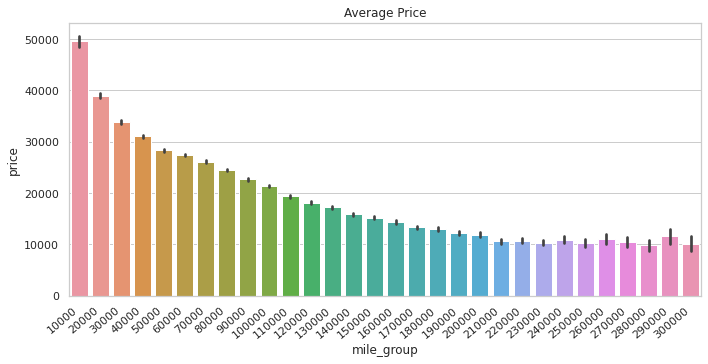

In [234]:
# 마일 그룹별 가격 평균 분포
ax = sns.barplot(x="mile_group", y="price", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Average Price')
plt.show()

In [235]:
df.fuel_type.nunique()
df.make.nunique()
df.engine_size.nunique()
df.engine_block.nunique()

3

In [236]:
df.columns

Index(['id', 'vin', 'price', 'miles', 'stock_no', 'year', 'make', 'model',
       'trim', 'body_type', 'vehicle_type', 'drivetrain', 'transmission',
       'fuel_type', 'engine_size', 'engine_block', 'seller_name', 'street',
       'city', 'state', 'zip', 'mile_group'],
      dtype='object')

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip,mile_group
137964,371c9637-43b2,WDDAK76F69M001877,630000.0,7788.0,PM4314,2009,Mercedes-Benz,SLR McLaren,Base,Convertible,...,Automatic,Premium Unleaded,5.4,V,rafih auto group,9275 Tecumseh Road East,Windsor,ON,N8R 1A1,10000
136818,ad3c08ca-6699,WDBSK79F99F158347,428888.0,4570.0,MU2622,2009,Mercedes-Benz,SL-Class,SL65 AMG,Coupe,...,Automatic,Premium Unleaded,6.0,V,h.j. pfaff motors,33 Auto Park Cir,Woodbridge,ON,L4L 8R1,10000
142243,e5824b67-aa6a,ZFFKW66A790167464,390000.0,18719.0,P0784,2009,Ferrari,F430,Scuderia,Coupe,...,Manual,Premium Unleaded,4.3,V,holand automotive group,8525 Boulevard Dcarie,Mont-royal,QC,H4P 2J2,20000
142239,2d184024-e5a0,ZFFFC60A290168170,199995.0,23330.0,U0474,2009,Ferrari,599,Base,Coupe,...,Automatic,Premium Unleaded,6.0,V,ferrari maserati of vancouver,1860 Burrard Street,Vancouver,BC,V6J 3H1,30000
142237,575652d9-d219,ZFFEW58AX90166572,155000.0,33969.0,ZFFEW58AX90166572,2009,Ferrari,F430,Base,Coupe,...,Automatic,Premium Unleaded,4.3,V,marianetti motors,6260 Highway 7,Vaughan,ON,L4H 4G3,40000
140322,e63f8c11-753b,WP0CD29949S773232,139888.0,21000.0,773232,2009,Porsche,911,Turbo,Convertible,...,Manual,Premium Unleaded,3.8,H,faraz auto sales,96 Signet Dr,Toronto,ON,M9L 1T2,30000
142251,0e8648ce-03c1,ZHWGU64T59LA08725,132900.0,15852.0,904555,2009,Lamborghini,Gallardo,Base,Roadster,...,Manual,Premium Unleaded,5.0,V,hgrgoire,625 Rue Dubois,Saint-eustache,QC,J7P 3W1,20000
140158,0c6521ac-78cf,WP0AA29979S707127,75985.0,40676.0,PU0066,2009,Porsche,911,Carrera,Coupe,...,Manual,Premium Unleaded,3.6,H,h.j. pfaff motors,33 Auto Park Cir,Woodbridge,ON,L4L 8R1,50000
136811,fc547d71-0e6a,WDBSK70F79F154522,73095.0,35500.0,NB2987746,2009,Mercedes-Benz,SL-Class,SL63 AMG,Convertible,...,Automatic,Premium Unleaded,6.2,V,mercedes-benz north vancouver,1375 Marine Drive,North Vancouver,BC,V7P 3E5,40000
125928,1b6f2bc7-c3d2,JN1AR54F79M250916,71888.0,41920.0,PS-8876,2009,Nissan,GT-R,Base,Coupe,...,Automatic,Premium Unleaded,3.8,V,house of cars edmonton,6103 91 Street Northwest,Edmonton,AB,T6E 6V6,50000


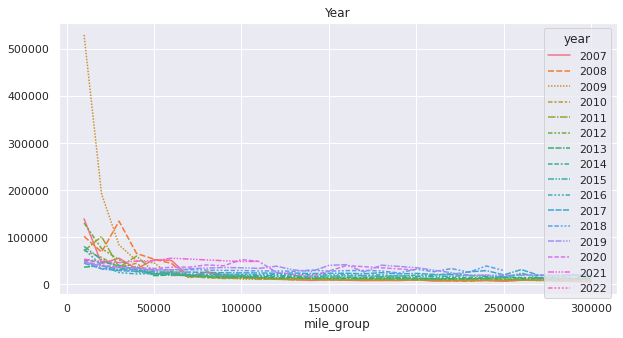

In [237]:
# mile에 따른 year의 가격 변화
year_pivot = pd.pivot_table(data=df, index='mile_group', columns='year', values='price', aggfunc='mean')
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(data=year_pivot).set(title='Year')
# 2009년 출시된 자동차의 5만 마일 이내 구간에서의 감가율이 매우 크다

df[(df.year==2009) & (df.miles<50000)].sort_values(by='price', ascending=False)
# 데이터 확인결과 Ferrari, Benz 등 럭셔리 카가 포함되어 있다

In [238]:
df[(df.year==2009) & (df.miles<50000)].sort_values(by='price', ascending=False)
# 럭셔리 카의 영향 확인인

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip,mile_group
137964,371c9637-43b2,WDDAK76F69M001877,630000.0,7788.0,PM4314,2009,Mercedes-Benz,SLR McLaren,Base,Convertible,...,Automatic,Premium Unleaded,5.4,V,rafih auto group,9275 Tecumseh Road East,Windsor,ON,N8R 1A1,10000
136818,ad3c08ca-6699,WDBSK79F99F158347,428888.0,4570.0,MU2622,2009,Mercedes-Benz,SL-Class,SL65 AMG,Coupe,...,Automatic,Premium Unleaded,6.0,V,h.j. pfaff motors,33 Auto Park Cir,Woodbridge,ON,L4L 8R1,10000
142243,e5824b67-aa6a,ZFFKW66A790167464,390000.0,18719.0,P0784,2009,Ferrari,F430,Scuderia,Coupe,...,Manual,Premium Unleaded,4.3,V,holand automotive group,8525 Boulevard Dcarie,Mont-royal,QC,H4P 2J2,20000
142239,2d184024-e5a0,ZFFFC60A290168170,199995.0,23330.0,U0474,2009,Ferrari,599,Base,Coupe,...,Automatic,Premium Unleaded,6.0,V,ferrari maserati of vancouver,1860 Burrard Street,Vancouver,BC,V6J 3H1,30000
142237,575652d9-d219,ZFFEW58AX90166572,155000.0,33969.0,ZFFEW58AX90166572,2009,Ferrari,F430,Base,Coupe,...,Automatic,Premium Unleaded,4.3,V,marianetti motors,6260 Highway 7,Vaughan,ON,L4H 4G3,40000
140322,e63f8c11-753b,WP0CD29949S773232,139888.0,21000.0,773232,2009,Porsche,911,Turbo,Convertible,...,Manual,Premium Unleaded,3.8,H,faraz auto sales,96 Signet Dr,Toronto,ON,M9L 1T2,30000
142251,0e8648ce-03c1,ZHWGU64T59LA08725,132900.0,15852.0,904555,2009,Lamborghini,Gallardo,Base,Roadster,...,Manual,Premium Unleaded,5.0,V,hgrgoire,625 Rue Dubois,Saint-eustache,QC,J7P 3W1,20000
140158,0c6521ac-78cf,WP0AA29979S707127,75985.0,40676.0,PU0066,2009,Porsche,911,Carrera,Coupe,...,Manual,Premium Unleaded,3.6,H,h.j. pfaff motors,33 Auto Park Cir,Woodbridge,ON,L4L 8R1,50000
136811,fc547d71-0e6a,WDBSK70F79F154522,73095.0,35500.0,NB2987746,2009,Mercedes-Benz,SL-Class,SL63 AMG,Convertible,...,Automatic,Premium Unleaded,6.2,V,mercedes-benz north vancouver,1375 Marine Drive,North Vancouver,BC,V7P 3E5,40000
125928,1b6f2bc7-c3d2,JN1AR54F79M250916,71888.0,41920.0,PS-8876,2009,Nissan,GT-R,Base,Coupe,...,Automatic,Premium Unleaded,3.8,V,house of cars edmonton,6103 91 Street Northwest,Edmonton,AB,T6E 6V6,50000


[Text(0.5, 1.0, 'Make')]

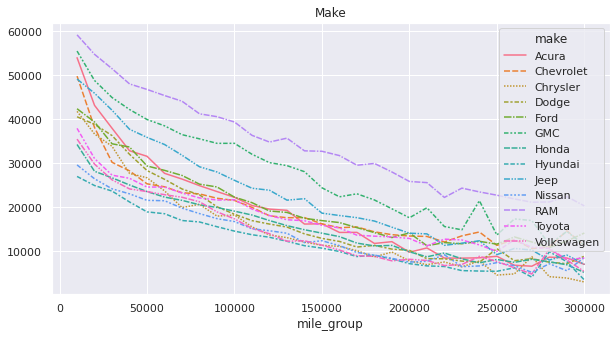

In [239]:
# mile에 따른 make별 가격 변화

make_pivot = pd.pivot_table(data=df, index='mile_group', columns='make', values='price', aggfunc='mean').dropna(axis=1) # 데이터 분포가 좁은 데이터, 럭셔리 maker 제외
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(data=make_pivot).set(title='Make')
# Acura, Chevrolet의 감가율 기울기가 상대적으로 급격하다

# sns.scatterplot(data=df, x='mile_group', y='price', hue='make')

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip,mile_group
1286,2d88bef0-f61c,WBY2Z6C54K7D31958,177600.0,1010.0,9D31958,2019,BMW,i8,Base,Targa,...,Automatic,Electric / Premium Unleaded,1.5,I,policaro bmw,5 Coachworks Crescent,Brampton,ON,L6R 3Y2,10000
1287,30af5f87-66b2,WBY2Z6C59K7D10619,131888.0,18260.0,21-0172A,2019,BMW,i8,Base,Targa,...,Automatic,Electric / Premium Unleaded,1.5,I,bmw newmarket,87 Mulock Drive,Newmarket,ON,L3Y 8V2,20000
117314,c1b1e73a-040e,1G1Y12D73K5106797,93194.0,30500.0,UP445,2019,Chevrolet,Corvette,3LT,Targa,...,Manual,Premium Unleaded,6.2,V,cavalcade ford,420 Ecclestone Drive,Bracebridge,ON,P1L 1R1,40000
117315,ba8c2042-300d,1G1Y12D74K5117209,100500.0,11882.0,21-046,2019,Chevrolet,Corvette,3LT,Targa,...,Manual,Premium Unleaded,6.2,V,camrose chrysler,3511 48 Avenue,Camrose,AB,T4V 0K9,20000
117316,37d2c3a6-4ba4,1G1Y12D75J5102670,95800.0,11859.0,PC6757,2018,Chevrolet,Corvette,3LT,Targa,...,Manual,Premium Unleaded,6.2,V,platinum cars.ca,60 Martin Ross Ave,North York,ON,M3J 2L4,20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140280,dfc62961-eae9,WP0BB2A96JS113467,132800.0,72000.0,JS113467,2018,Porsche,911,Targa 4S,Targa,...,Manual,Premium Unleaded,3.0,H,paramount fine cars inc,4467 Chesswood Drive North York,Toronto,ON,M3J 2C2,80000
142019,4a8513be-1766,ZARBAAB40GM179158,74888.0,13126.0,A10002,2016,Alfa Romeo,4C,Spider,Targa,...,Automatic,Premium Unleaded,1.7,I,des sources alfa romeo,3352 Boulevard Des Sources,Dollard-des-ormeaux,QC,H9B 1Z9,20000
142020,83e858df-d157,ZARBAAB40GM182111,65456.0,6191.0,255060,2016,Alfa Romeo,4C,Spider,Targa,...,Automatic,Premium Unleaded,1.7,I,autocanada,200 15511 123 Ave Nw,Edmonton,AB,T5V 0C3,10000
142021,ad604618-90a7,ZARBAAB42GM182109,67990.0,15856.0,P4148-MAZ,2016,Alfa Romeo,4C,Spider,Targa,...,Automatic,Premium Unleaded,1.7,I,mazda drummondville,1295 Boulevard Saint-joseph,Drummondville,QC,J2C 2E2,20000


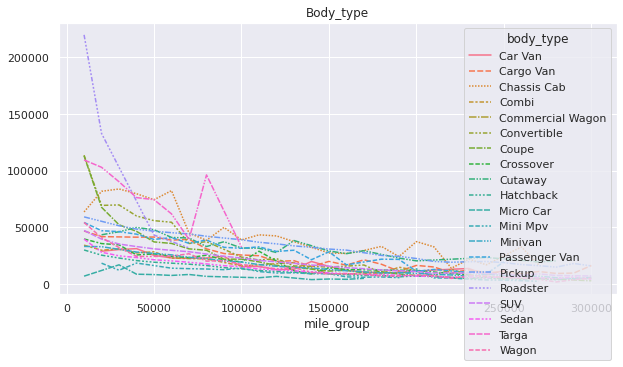

In [240]:
# 마일별 body_type별 가격비교
btype_pivot = pd.pivot_table(data=df, index='mile_group', columns='body_type', values='price', aggfunc='mean') 
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(data=btype_pivot).set(title='Body_type')
# Roadster 타입의 바디타입의 5만 마일 이내 감가율이 상당히 크다
# Targa 타입이 감소하다가 급상승한다

df[df['body_type']=='Roadster'] #6개
df[df['body_type']=='Targa']    #130개
# 데이터 확인 결과, 럭셔리 카에서 나오는 주로 나오는 바디타입인데, 데이터의 수가 부족하기도 하고, 초고가의 럭셔리카가 섞여있기 때문으로 보인다

[Text(0.5, 1.0, 'Vehicle_type')]

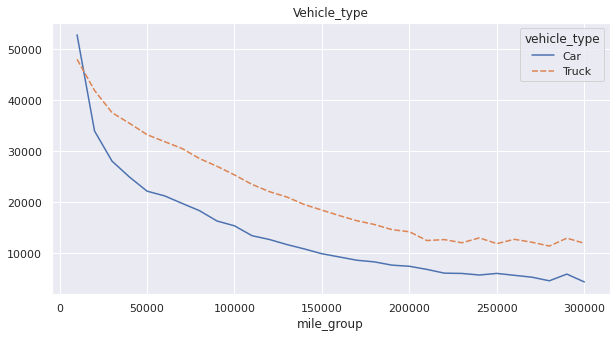

In [241]:
# 마일별 vehicle_type별 가격비교
vtype_pivot = pd.pivot_table(data=df, index='mile_group', columns='vehicle_type', values='price', aggfunc='mean')
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(data=vtype_pivot).set(title='Vehicle_type')
# Car 타입이 Truck타입에 비해 감가율이 크다 (외형보다 실질이 큰 영향을 미쳤다다)

[Text(0.5, 1.0, 'Drivetrain')]

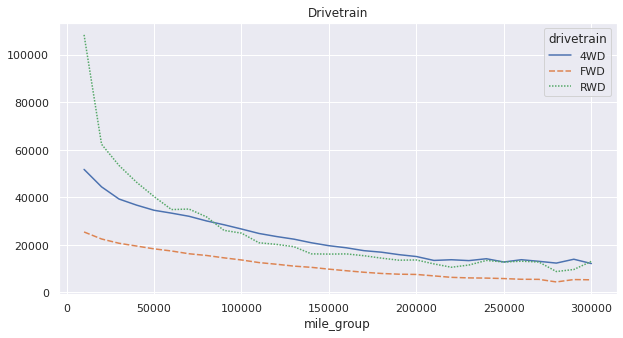

In [242]:
# 마일별 drivetrain별 가격비교
drivetrain_pivot = pd.pivot_table(data=df, index='mile_group', columns='drivetrain', values='price', aggfunc='mean')
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(data=drivetrain_pivot).set(title='Drivetrain')
# RWD 타입의 5만 마일 이내 감가율이 크다 (--> 럭셔리카의 영향으로 추정할 수 있다)

[Text(0.5, 1.0, 'Transmission')]

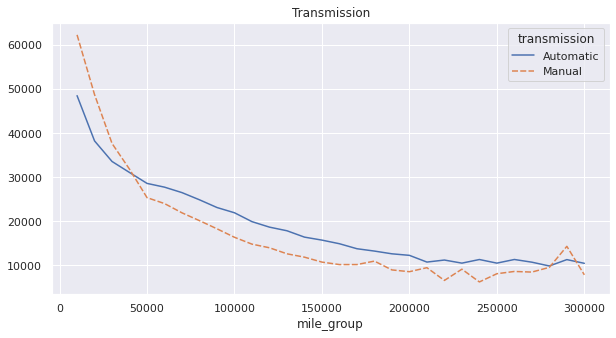

In [243]:
# 마일별 transmission별 가격비교
transmission_pivot = pd.pivot_table(data=df, index='mile_group', columns='transmission', values='price', aggfunc='mean')
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(data=transmission_pivot).set(title='Transmission')
# Manual의 감가율이 약간 크다(별 차이 없다다)

[Text(0.5, 1.0, 'Engine_block')]

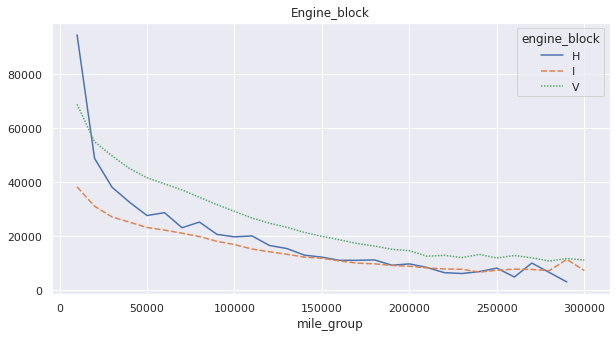

In [244]:
# 마일별 engine_block별 가격비교
engine_block_pivot = pd.pivot_table(data=df, index='mile_group', columns='engine_block', values='price', aggfunc='mean')
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(data=engine_block_pivot).set(title='Engine_block')


In [245]:
df[df['engine_block']=='H'].make.value_counts()
# H의 감가율이 크다(특수한 경우에 쓰는 엔진으로 데이터양이 미미해서 왜곡 가능성성) 

Subaru     1719
Porsche     129
Toyota       28
Scion        25
Name: make, dtype: int64

In [246]:
# mile별 분석 종합
# year : 2009년 출시된 자동차의 5만 마일 이내 구간에서의 감가율이 매우 크다 (럭셔리카의 영향)
# make : Acura, Chevrolet의 감가율 기울기가 상대적으로 급격하다
# body_type : Roadster, Targa 타입의 마일수에 따른 변화가 상당히 크다 (럭셔리카의 영향)
# vehicle_type : Car 타입이 Truck타입에 비해 감가율이 크다 (럭셔리카의 영향)
# drivetrain: RWD 타입의 5만 마일 이내 감가율이 크다 (럭셔리카의 영향)
# transmission : 별 차이 없다
# engine block은 대체로 engine_size에 수반된다. i == 소형, v == 대형(6기통 이상), h == 특수한 경우이고 비율이 미미하다.

## 전체적으로, 럭셔리카의 영향을 배제하면 개별 특성별 mile에 따른 가격 추이에 특이점 없이 거의 일정한 반비례 관계를 보여준다

  **2) year별 데이터 분석**

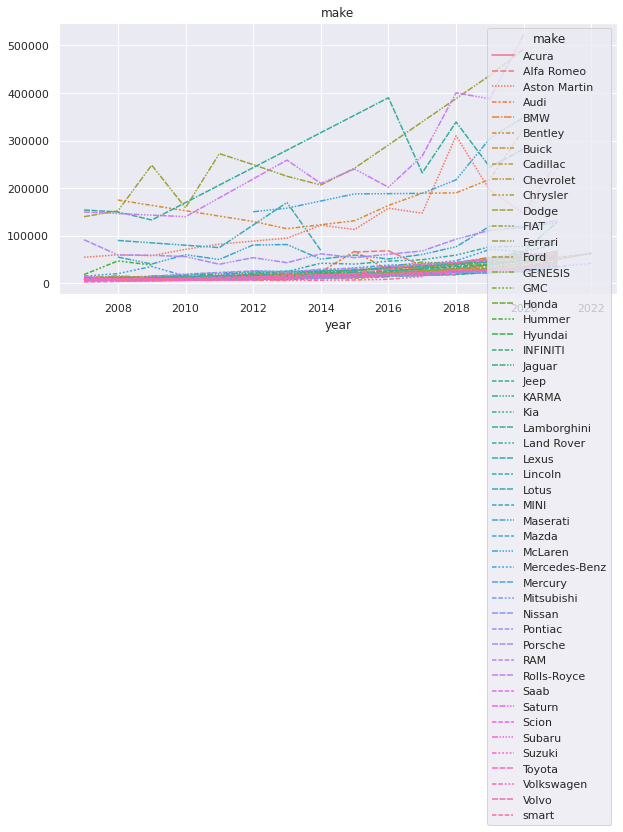

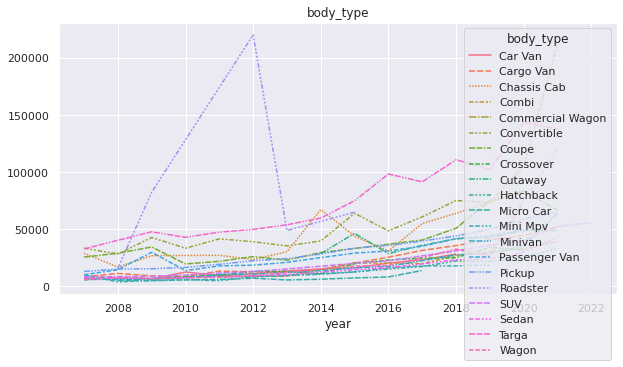

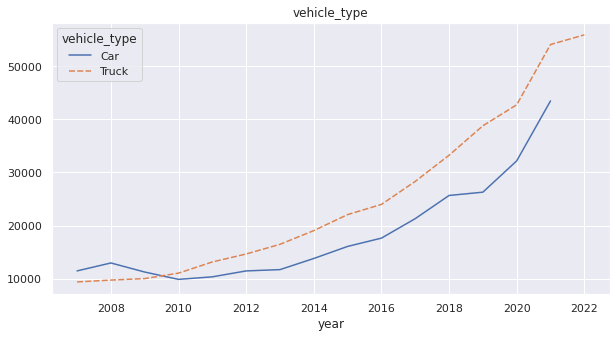

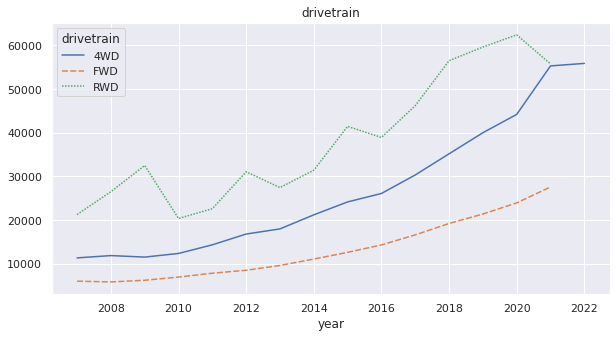

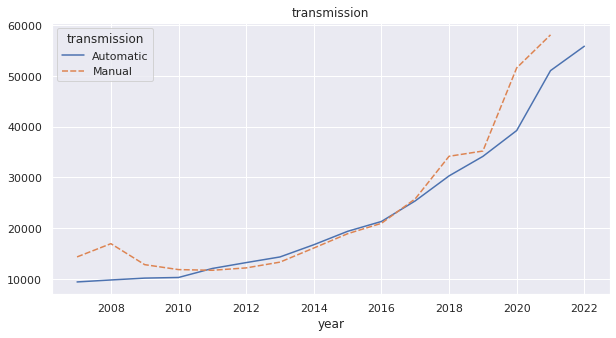

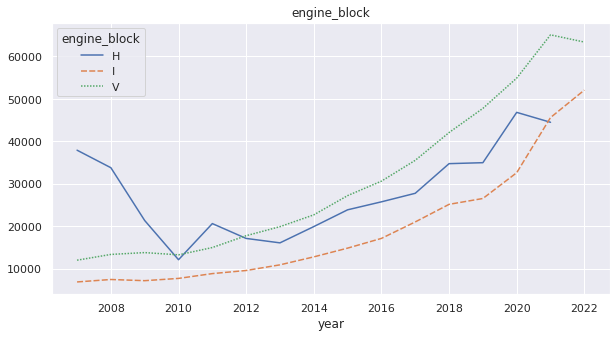

In [247]:
# year에 따른 특성들의 가격 변화('miles', 'make', 'body_type', 'vehicle_type', 'drivetrain', 'transmission', 'fuel_type', 'engine_size', 'engine_block')
for feature in ['make', 'body_type', 'vehicle_type', 'drivetrain', 'transmission', 'engine_block']:
  pivot = pd.pivot_table(data=df, index='year', columns=feature, values='price', aggfunc='mean')
  sns.set(rc = {'figure.figsize':(10,5)})
  sns.lineplot(data=pivot).set(title=f'{feature}')
  plt.show()
# make : 가격대가 높은 자동차의 경우 출시 년도가 오래될수록 더욱 더 감가율이 크다다
# body_type : 럭셔리카가 많은 바디 타입의 경우(Targa>Convertible>Chassis Cab(Truck)>Coupe) 출시년도에 따른 감가율율이 크다 (Roadster의 특이성은 mile별 분석에서 럭셔리카의 영향 확인)
# vehicle_type : Truck의 출시년도에 따른 감가율율이 약간 더 크다
# drivetrain : 출시년도에 따른 별다른 특이점이 없고 전반적으로 RWD > 4WD > FWD 가격 경향이다
# transmission : 출시년도에 따른 별다른 특이점이 없다
# engine_block : H 타입의 경우 2010년 이전에는 출시년도가 2010년 이전의 경우 반대로 증가한다(mile 분석에서 데이터 왜곡 확인 )

## 전체적으로, 가격대가 높은 자동차나 럭셔리카 메이커, Truck일 경우 출시연도가 오래될수록 감가율이이 더 높다

**3) 주요 도시의 데이터 분석**

In [248]:
df_mainct = df[(df.city == 'Toronto') | (df.city == 'Vancouver') | (df.city == 'Montreal') | (df.city == 'Calgary') | (df.city == 'Ottawa')]
df_not_mainct = df.drop(df_mainct.index)

In [249]:
df_mainct

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip,mile_group
8,031632fa-66c6,19UNC1B08HY800043,178888.0,13500.0,2017NSXWHITE,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,northwest acura,125 Crowfoot Way Northwest,Calgary,AB,T3G 2R2,20000
20,3e6f90ab-34b4,1FTEW1E50JFA50359,39980.0,90439.0,960430,2018,Ford,F-150,XLT,Pickup,...,Automatic,E85 / Unleaded; Unleaded / Unleaded,5.0,V,campbell ford,1500 Carling Avenue (carling At The Queensway),Ottawa,ON,K1Z 0A3,100000
28,15d93058-4168,1FTEW1E50JFE52303,34499.0,50500.0,FE52303,2018,Ford,F-150,XLT,Pickup,...,Automatic,Unleaded / Unleaded,5.0,V,revmotors,1800 Bank St #2b,Ottawa,ON,K1V 0W3,60000
29,5870cb37-5840,1FTEW1E50JKC36264,50997.0,46198.0,19-389A,2018,Ford,F-150,Lariat,Pickup,...,Automatic,Unleaded / Unleaded,5.0,V,dan murphy ford service,1346 Bankfield Road Manotick,Ottawa,ON,K4M 1A7,50000
53,8e8b5596-5f28,1FTEW1E53JKD47746,38990.0,88735.0,MK-75A,2018,Ford,F-150,XLT,Pickup,...,Automatic,Unleaded / Unleaded,5.0,V,calgary motor dealers assn,11505 35 Street Southeast #107,Calgary,AB,T2Z 4B1,90000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145090,06e82e6c-5c6e,WBA8E1C54HK895135,24495.0,29118.0,14088A,2017,BMW,3 Series,330e,Sedan,...,Automatic,Electric / Unleaded,2.0,I,elite bmw,1040 Ogilvie Road Gloucester,Ottawa,ON,K1J 8G9,30000
145094,bfed0012-44a2,WDC0G5EB0JV021142,45880.0,69000.0,C1142-3-7,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,curve motors,1850 Lawrence Avenue East Scarborough,Toronto,ON,M1R 2Y4,70000
145096,df45db82-92fd,WDC0G5EB1JV036555,43880.0,65000.0,C65550,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,curve motors,1850 Lawrence Avenue East Scarborough,Toronto,ON,M1R 2Y4,70000
145098,1383a75d-b816,WDC0G5EB2JF471451,46800.0,19833.0,17759,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,world fine cars,520 Kipling Avenue Etobicoke,Toronto,ON,M8Z 5E3,20000


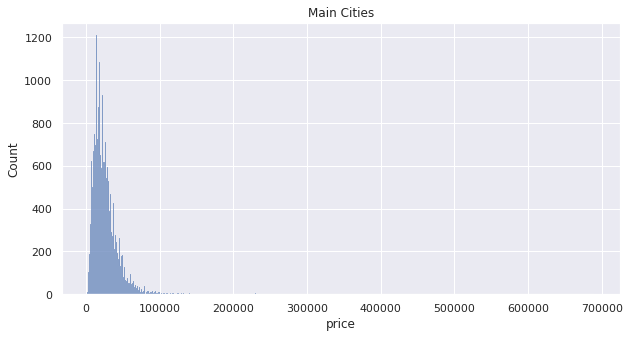

In [250]:
# 주요 도시의 가격 분포포
sns.histplot(df_mainct.price).set_title('Main Cities');
# sns.histplot(df_mainct[df_mainct.price<100000].price);

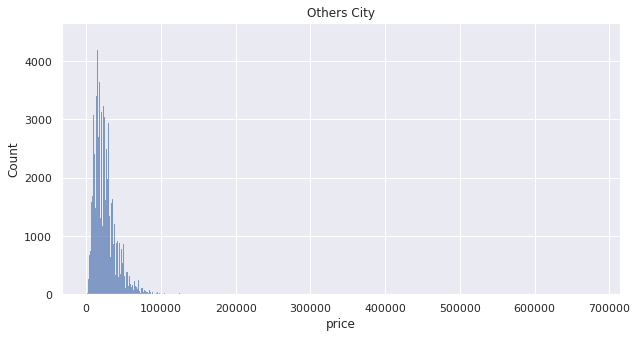

In [251]:
# 비비주요 도시의 가격 분포
sns.histplot(df_not_mainct.price).set_title('Others City');
# sns.histplot(df_not_mainct[df_not_mainct.price<100000].price);

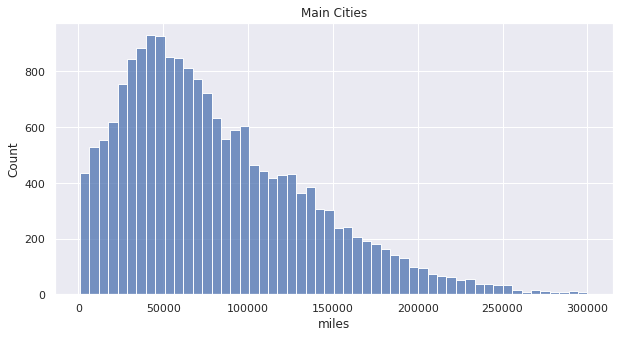

In [252]:
# 주요 도시의 마일수 분포포
sns.histplot(df_mainct.miles).set_title('Main Cities');

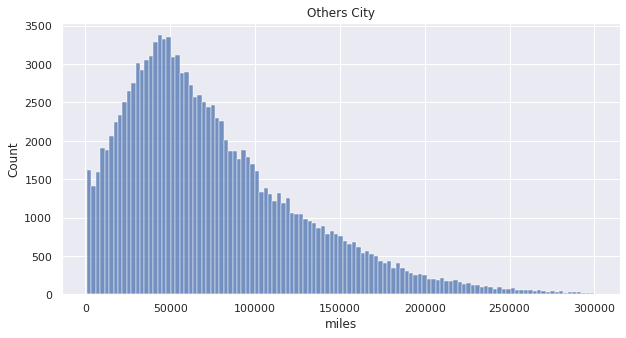

In [253]:
# 비주요 도시의 마일수 분포포
sns.histplot(df_not_mainct.miles).set_title('Others City');

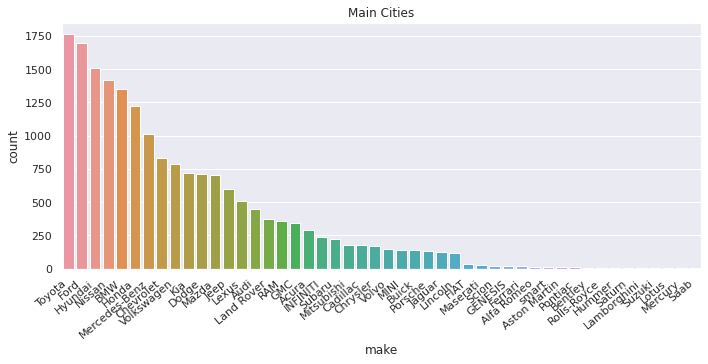

In [254]:
# 주요 도시의 인기 차 메이커커
ax = sns.countplot(x="make", data=df_mainct, order = df_mainct['make'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Main Cities')
plt.show()

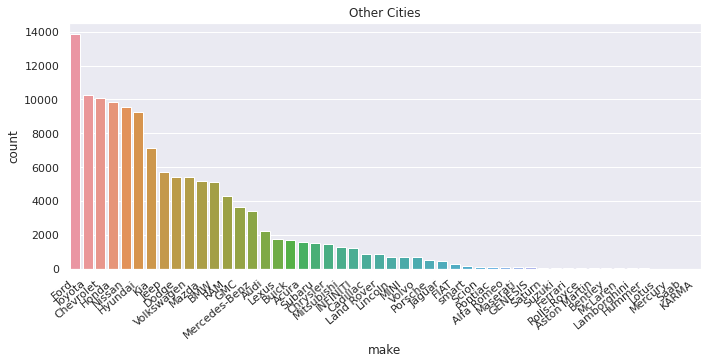

In [255]:
# 비주요 도시의 인기 차 메이커커
ax = sns.countplot(x="make", data=df_not_mainct, order = df_not_mainct['make'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Other Cities')
plt.show()

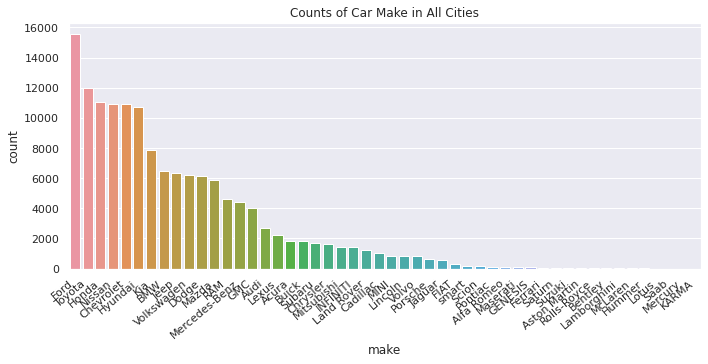

In [256]:
# 전체 데이터의 인기 차 메이커커
ax = sns.countplot(x="make", data=df, order = df['make'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Counts of Car Make in All Cities')
plt.show()

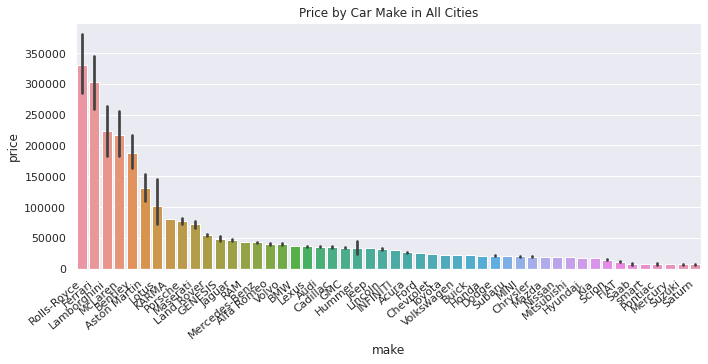

In [257]:
# 메이커별 가격대
order = df.groupby(["make"])["price"].mean().sort_values(ascending=False).index
ax = sns.barplot(x="make", y='price', data=df, order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Price by Car Make in All Cities')
plt.show()

In [258]:
# 주요 도시와 그 외 도시간의 가격 분포와 마일 분포에는 큰 차이가 없다. 
# 주요 도시에서 인기 있는 메이커커는 Toyota > Ford > Hyundai > Nissan > BMW, 비주요 도시는 Ford >> Toyota > Chevrolet > Honda > Nisan순
# 전체 데이터의 인기 있는 메이커는 Ford이고, 전체적으로 인기 있는 메이커들은 전체 메이커 대비 중저가에 위치한다다

**3.  ML 모델링 분석**

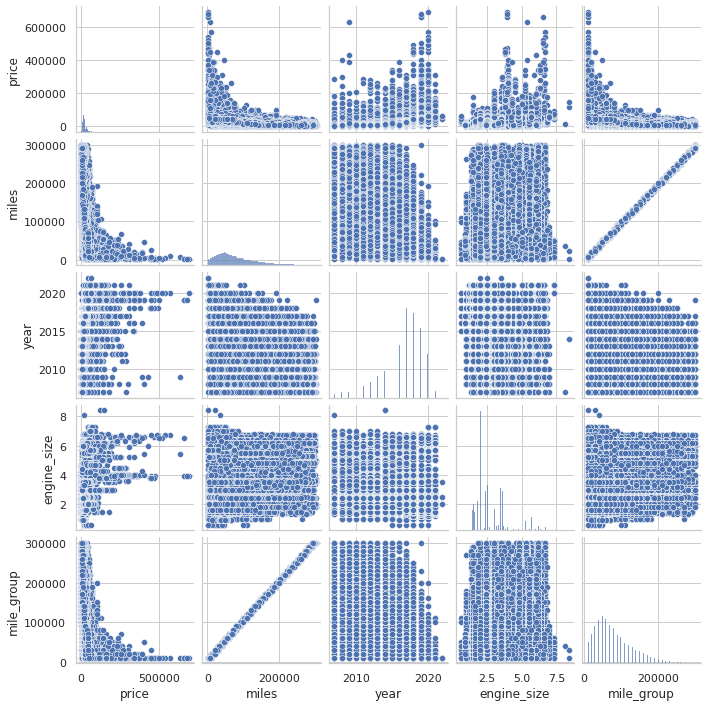

In [259]:
# 개별특성과 price 간 상관관계 확인인
# 수치형 특성-price 간 상관관계 pairplot으로 확인인
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, height=2)
# price-mile 의 반비례 관계, price-year, price-engine_size의 정비례 관계 확인
# price의 데이터 분포의 비대칭을 감안한다

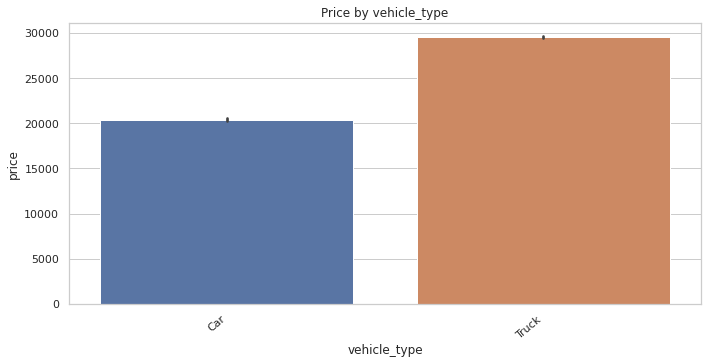

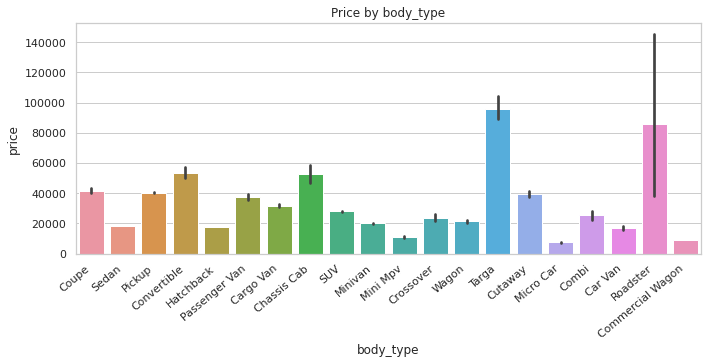

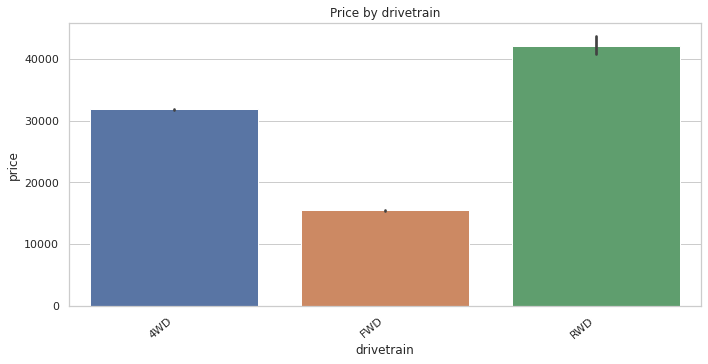

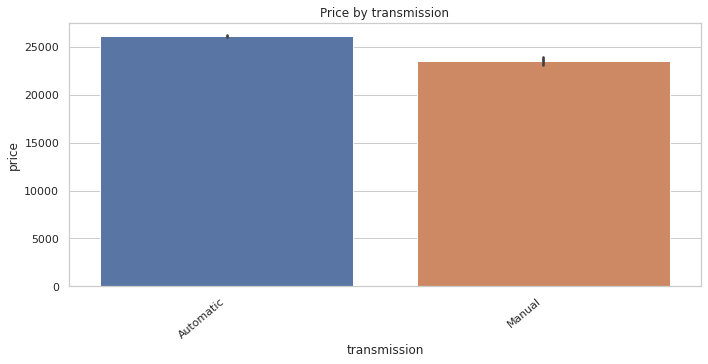

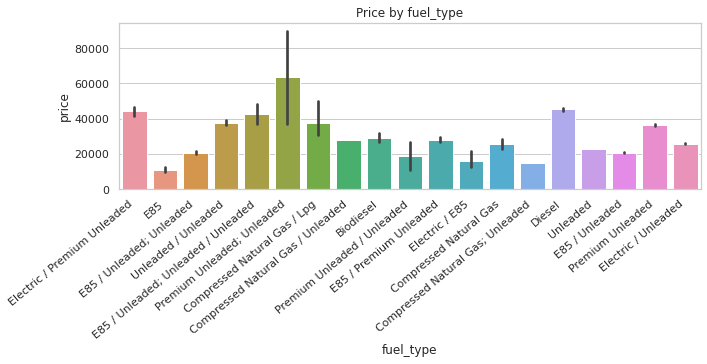

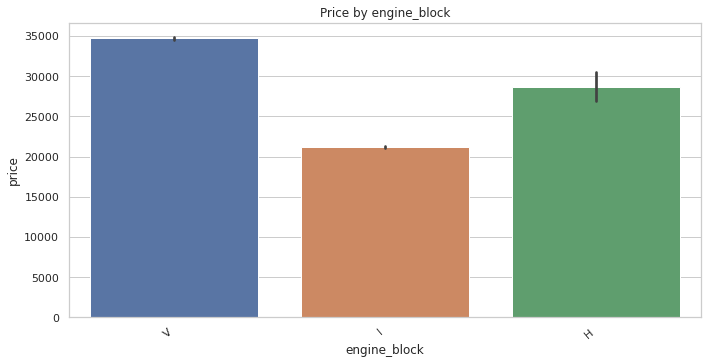

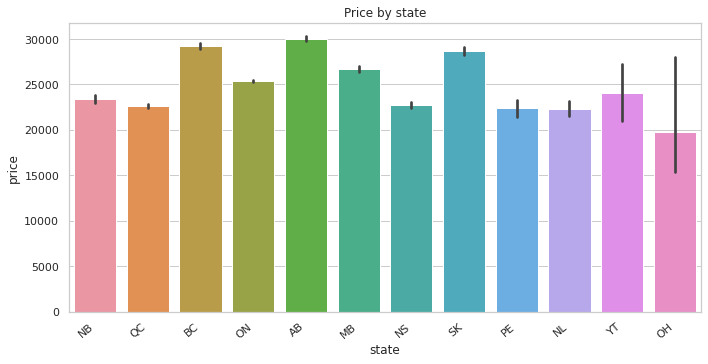

'\nsns.heatmap(df, cmap=sns.light_palette(\n    "gray", as_cmap=True), annot=True, fmt="d")\nplt.title("Heatmap")\nplt.show()\n'

In [260]:
# 카테고리형 특성-price 간 상관관계 개괄적 확인
for feature in ['vehicle_type', 'body_type', 'drivetrain', 'transmission', 'fuel_type', 'engine_block', 'state']:
  ax = sns.barplot(x=feature, y="price", data=df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  plt.title(f"Price by {feature}")
  plt.show()
'''
ax = sns.barplot(x="mile_group", y="price", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()
'''


'''
sns.heatmap(df, cmap=sns.light_palette(
    "gray", as_cmap=True), annot=True, fmt="d")
plt.title("Heatmap")
plt.show()
'''

In [261]:
# 타겟 설정
df['price'].skew()
# 왜도율이 매우 높으므로 회귀분석을 위해서 변환이 필요함

6.478081987058784

In [262]:
# price의 로그변환
df['price'] = np.log(df['price'])
df

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip,mile_group
0,b39ea795-eca9,19UNC1B01HY800062,12.100707,9966.0,V-P4139,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7,10000
1,026cb5b1-6e3e,19UNC1B02HY800023,12.100684,5988.0,PPAP70374,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0,10000
2,5cd5d5b2-5cc2,19UNC1B02HY800071,12.034857,24242.0,B21085,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4,30000
3,b32473ed-5922,19UNC1B02LY800001,12.301383,6637.0,AP5333,2020,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2,10000
4,0487af07-893c,19UNC1B03HY800063,11.956142,18281.0,U02856,2017,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,gravel auto crdit,102-1007 Boulevard Ren Lvesque Verdun,Montral,QC,H3E 0H1,20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145106,12c697a9-e4aa,WDC0G5EB7JV031599,10.744796,58514.0,BA1599,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,pioneer auto group,33349 1 Avenue,Mission,BC,V2V 1G8,60000
145107,a02fbcbc-9f63,WDC0G5EB7JV034017,10.689670,68665.0,E-0069,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,hyundai repentigny,845 Rue Notre Dame,Repentigny,QC,J5Y 1C4,70000
145108,f71c5738-33d8,WDC0G5EB8KF614677,10.778852,22108.0,M0684,2019,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,mercedes-benz granby,1225 Rue Principale,Granby,QC,J2J 0M3,30000
145109,873d76f0-18d2,WDC0G5EB9JF465808,10.668839,55316.0,D13339,2018,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,Automatic,Electric / Unleaded,2.0,I,groupe park avenue - regroupement automobile,8840 Boulevard Taschereau,Brossard,QC,J4X 1C2,60000


In [263]:
df.columns

Index(['id', 'vin', 'price', 'miles', 'stock_no', 'year', 'make', 'model',
       'trim', 'body_type', 'vehicle_type', 'drivetrain', 'transmission',
       'fuel_type', 'engine_size', 'engine_block', 'seller_name', 'street',
       'city', 'state', 'zip', 'mile_group'],
      dtype='object')

-0.148401717320593


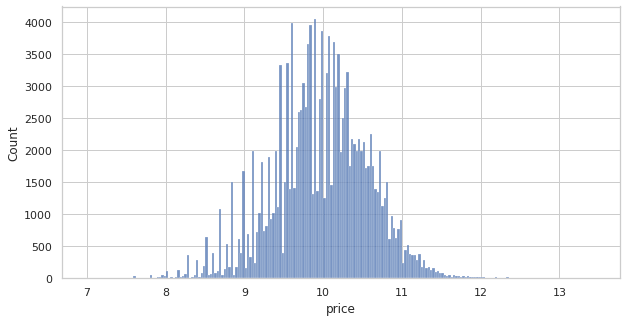

In [264]:
from scipy import stats
import numpy as np

# 로그변환 결과 확인
# price_log = np.log(train['price'])
print(df['price'].skew())
sns.histplot(df['price']);
# 왜도 완화화

In [265]:
# 데이터 분리 for modeling
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=2)
train.shape, test.shape
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=2)
train.shape, val.shape, test.shape

target = 'price'
features = df.columns.drop([target, 'id', 'vin', 'model', 'seller_name', 'stock_no', 'street', 'zip', 'mile_group']) # high-cardinality 컬럼 및 데이터 확인 위해 추가했던 'mile_group' 삭제
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]


In [266]:
# target_boxcox = stats.boxcox(train['price'])[0]
# pd.Series(target_boxcox).skew()
# sns.histplot(pd.Series(target_boxcox));

## box-cox transform이 가장 왜도가 줄어드므로 왜도수정방법으로 선택 
# box-cox transform 함수 작성
# def bc_trans(df):
  # df_bc = stats.boxcox(df['price'])[0]
  # return df_bc

# print(pd.Series(bc_trans(train)).skew())
# sns.histplot(pd.Series(bc_trans(train)));

In [267]:
# 회귀 기준(base) 모델 설정
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

major = y_train.mean()
major
y_pred = [major] * len(y_train)
y_pred
mae = mean_absolute_error(y_train, y_pred)
print("기준모델 훈련스코어: ", mae)
y_pred = [major] * len(y_val)
mae = mean_absolute_error(y_val, y_pred)
print("기준모델 검증스코어: ", mae)
r2 = r2_score(y_val, y_pred)
print("기준모델 검증증스코어 r2: ", r2)

기준모델 훈련스코어:  0.4789325895534797
기준모델 검증스코어:  0.47712700890082604
기준모델 검증증스코어 r2:  -0.00011829107928984506


In [268]:
# Ridge 회귀 학습
from category_encoders.one_hot import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression),
    Ridge()  # LinearRegression모델의 경우 심한 과적합을 보이므로 Ridge사용
)

dists = {
    # 'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

pipe = clf.best_estimator_

y_pred1 = pipe.predict(X_train)
mae1 = mean_absolute_error(y_train, y_pred1)
y_pred2 = pipe.predict(X_val)
mae2 = mean_absolute_error(y_val, y_pred2)
r2 = r2_score(y_val, y_pred2)
print(f"훈련 mae 에러: {mae1}")
print(f"검증 mae 에러: {mae2}")
print(f"검증 r2 에러: {r2}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
최적 하이퍼파라미터:  {'selectkbest__k': 13, 'ridge__alpha': 10}
MAE:  0.19143233185180877
훈련 mae 에러: 0.19139951809854136
검증 mae 에러: 0.19126369540562424
검증 r2 에러: 0.8249733614890584


In [269]:
# 회귀분석 모델의 상관계수 분석
# coeff = pd.Series(pipe.named_steps.ridge.coef_, X_train.columns)
print(pipe.named_steps.ridge.coef_)
X_trans = pipe.named_steps['onehotencoder'].fit_transform(X_train)
all_names = X_trans.columns
selected_mask = pipe.named_steps['selectkbest'].get_support()
selected_name = all_names[selected_mask]
print(selected_name)
coeff = pd.Series(pipe.named_steps.ridge.coef_, selected_name).sort_values(ascending=False)
print(coeff)

[-0.16912939  0.27431587 -0.01542266  0.0180961   0.00727246 -0.00727246
 -0.00442045 -0.15830613  0.07474307 -0.05007586  0.19553572 -0.00185375
  0.0239497 ]
Index(['miles', 'year', 'body_type_2', 'body_type_5', 'vehicle_type_1',
       'vehicle_type_2', 'drivetrain_1', 'drivetrain_2', 'fuel_type_1',
       'fuel_type_2', 'engine_size', 'engine_block_1', 'engine_block_2'],
      dtype='object')
year              0.274316
engine_size       0.195536
fuel_type_1       0.074743
engine_block_2    0.023950
body_type_5       0.018096
vehicle_type_1    0.007272
engine_block_1   -0.001854
drivetrain_1     -0.004420
vehicle_type_2   -0.007272
body_type_2      -0.015423
fuel_type_2      -0.050076
drivetrain_2     -0.158306
miles            -0.169129
dtype: float64


In [270]:
# pipe.named_steps['onehotencoder'].mapping

In [271]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(random_state=2)
)
'''
k = 3

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
'''
dists = {     
    # 'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 200), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipeline, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);


print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

pipeline = clf.best_estimator_
print("검증 r2 score", pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print("검증 mae score: ", mae)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
최적 하이퍼파라미터:  {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 0.5551089214206874, 'randomforestregressor__n_estimators': 140}
MAE:  0.0987963449387565
검증 r2 score 0.9467156667646566
검증 mae score:  0.09505070550381456


In [272]:
# 랜덤포레스트 모델에서의 특성 중요도(MDA) 분석
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestRegressor(random_state=2))
])
pipe.fit(X_train, y_train)

permuter = PermutationImportance(
    pipe.named_steps['rf'],
    n_iter=5,
    random_state=2
)

X_val_trans = pipe.named_steps['preprocessing'].transform(X_val)
permuter.fit(X_val_trans, y_val)

PermutationImportance(estimator=RandomForestRegressor(random_state=2),
                      random_state=2)

In [273]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()
# 특성 전부 순열 중요도 값이 양수이므로로 제거해서 얻을 모델 성능 향상을 기대할 수 없다
# 그러나 미미한 중요도를 가지는 특성들들은 제거하여 학습 속도 향상을 기대할 수 있다

city            0.001410
engine_block    0.002438
transmission    0.008727
state           0.012174
vehicle_type    0.018474
body_type       0.027296
trim            0.035055
make            0.062923
fuel_type       0.078819
miles           0.123347
drivetrain      0.147243
engine_size     0.467917
year            0.550449
dtype: float64

In [274]:
# Gradient Boosting 
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

boosting = XGBRegressor(
    n_estimators=2000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=100
         )

[0]	validation_0-rmse:7.60087	validation_1-rmse:7.59548
[1]	validation_0-rmse:6.08354	validation_1-rmse:6.07913
[2]	validation_0-rmse:4.86994	validation_1-rmse:4.86627
[3]	validation_0-rmse:3.89936	validation_1-rmse:3.89644
[4]	validation_0-rmse:3.12326	validation_1-rmse:3.12108
[5]	validation_0-rmse:2.50287	validation_1-rmse:2.50094
[6]	validation_0-rmse:2.00726	validation_1-rmse:2.00578
[7]	validation_0-rmse:1.61152	validation_1-rmse:1.61032
[8]	validation_0-rmse:1.29578	validation_1-rmse:1.29512
[9]	validation_0-rmse:1.04432	validation_1-rmse:1.04374
[10]	validation_0-rmse:0.84466	validation_1-rmse:0.84449
[11]	validation_0-rmse:0.68662	validation_1-rmse:0.68670
[12]	validation_0-rmse:0.56199	validation_1-rmse:0.56251
[13]	validation_0-rmse:0.46443	validation_1-rmse:0.46524
[14]	validation_0-rmse:0.38916	validation_1-rmse:0.39025
[15]	validation_0-rmse:0.33154	validation_1-rmse:0.33297
[16]	validation_0-rmse:0.28801	validation_1-rmse:0.28981
[17]	validation_0-rmse:0.25596	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [275]:
y_pred = boosting.predict(X_val_encoded)
print('R^2', r2_score(y_val, y_pred))
print('mae', mean_absolute_error(y_val, y_pred))
# 최고 성능을 보여주는 모델

R^2 0.9585300746256971
mae 0.08455670175557572


In [276]:
# 그래디언트부스팅 모델에서의 특성 중요도(MDA) 분석
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', XGBRegressor(n_estimators=2000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1))
])
pipe.fit(X_train, y_train)

permuter = PermutationImportance(
    pipe.named_steps['rf'],
    n_iter=5,
    random_state=2
)

X_val_trans = pipe.named_steps['preprocessing'].transform(X_val)
permuter.fit(X_val_trans, y_val)

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

transmission    0.003305
city            0.005724
engine_block    0.008013
state           0.018611
body_type       0.024902
vehicle_type    0.025942
fuel_type       0.033574
trim            0.043468
drivetrain      0.063420
make            0.098383
miles           0.145488
engine_size     0.318414
year            0.419470
dtype: float64

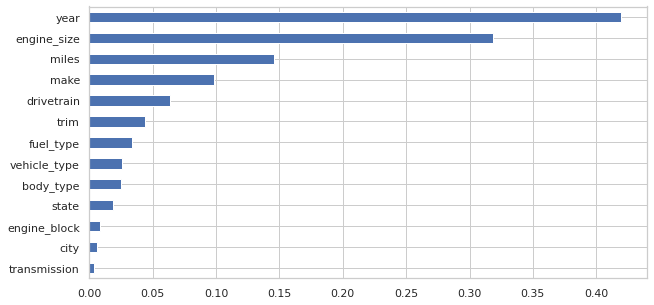

In [277]:
# plt.barh(feature_names, permuter.feature_importances_);
pd.Series(permuter.feature_importances_, feature_names).sort_values().plot.barh()

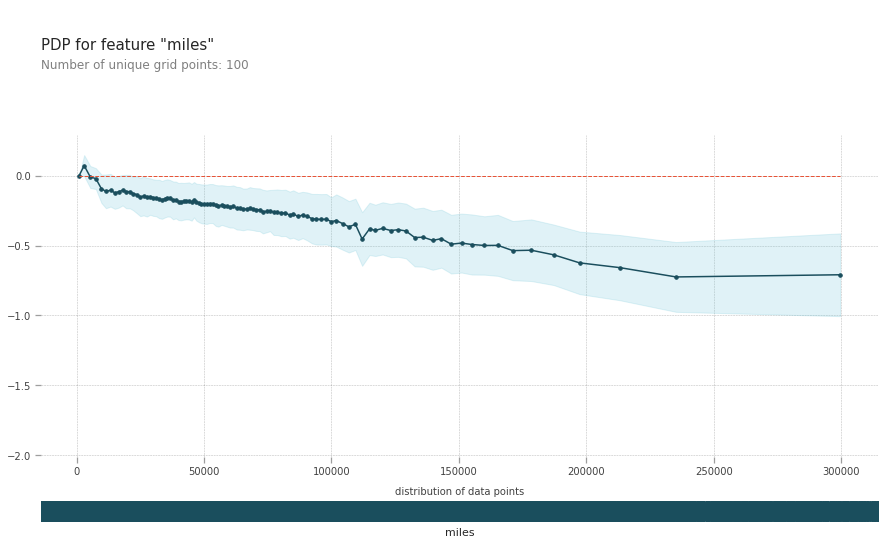

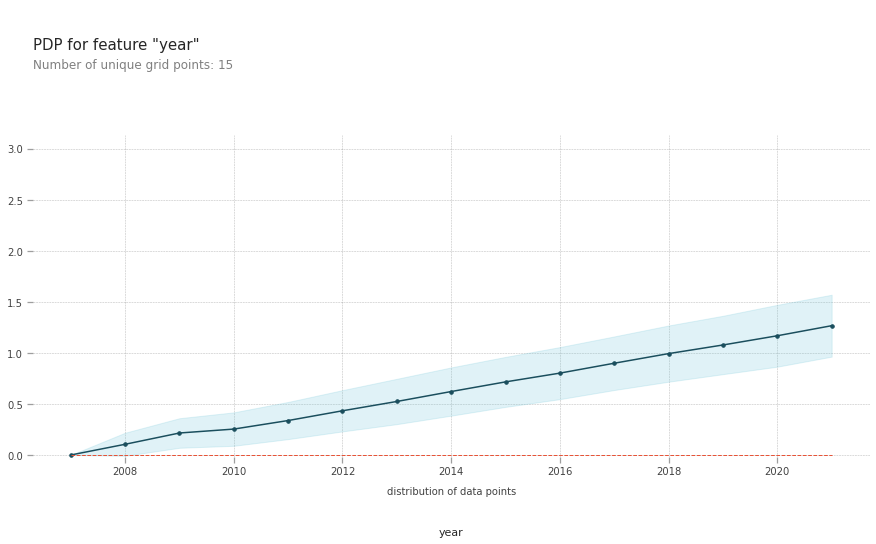

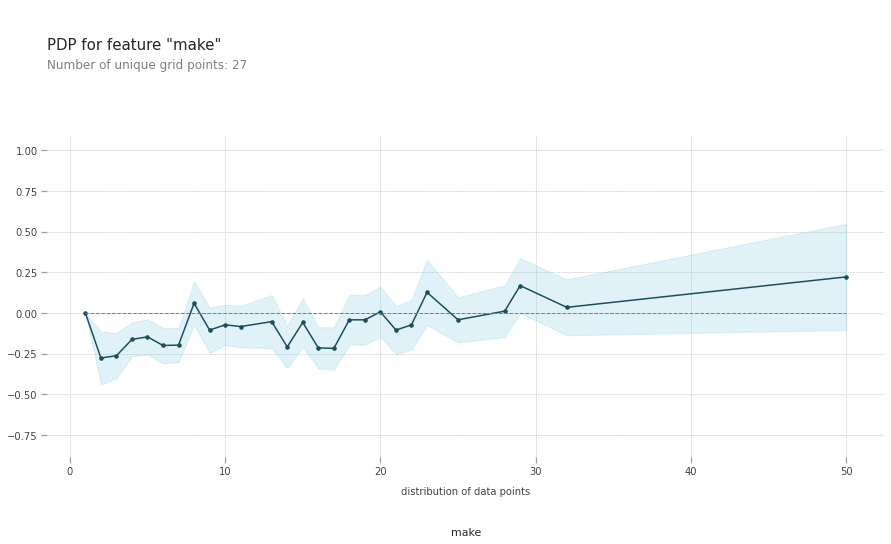

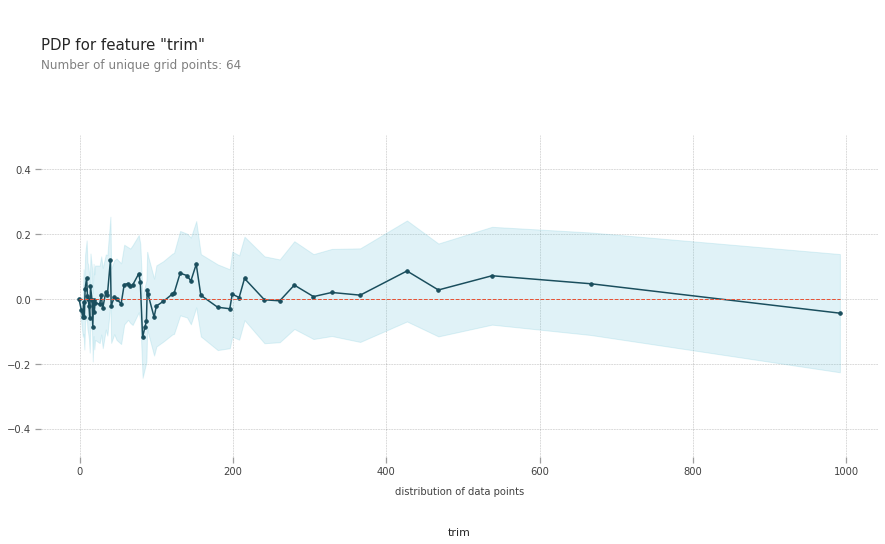

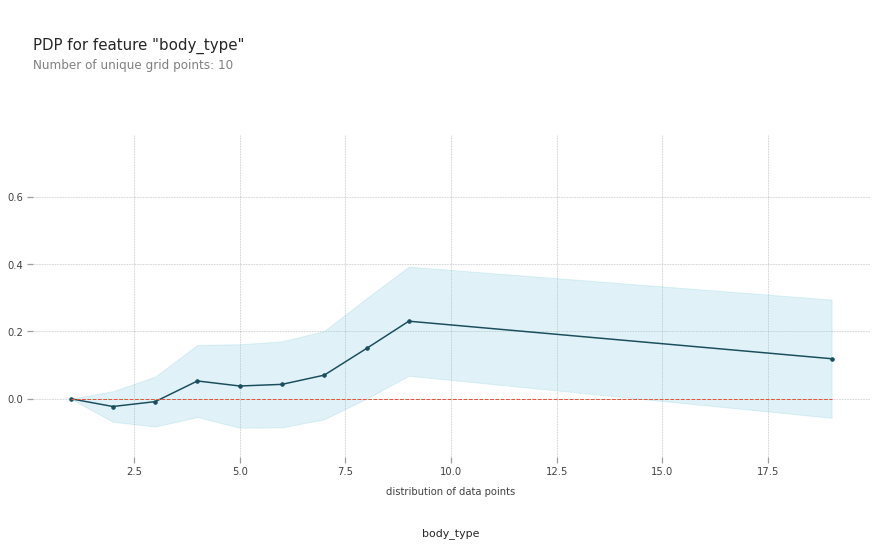

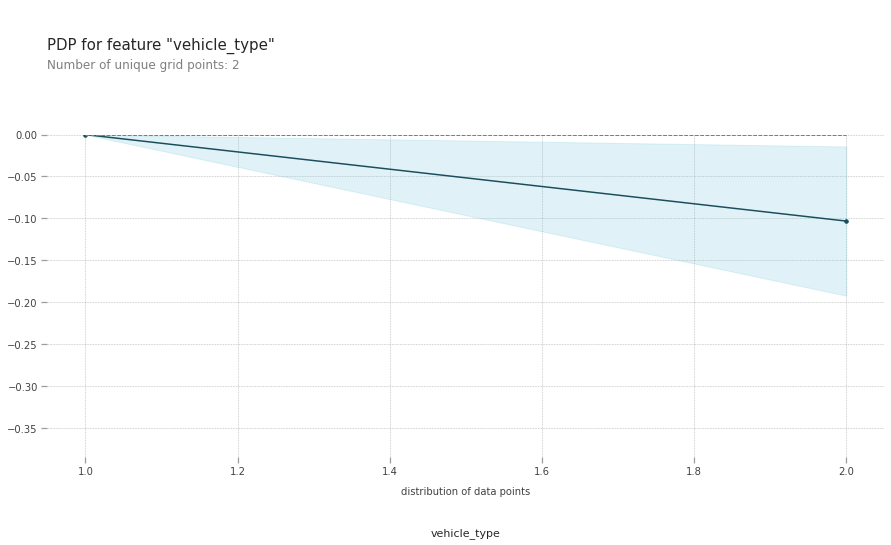

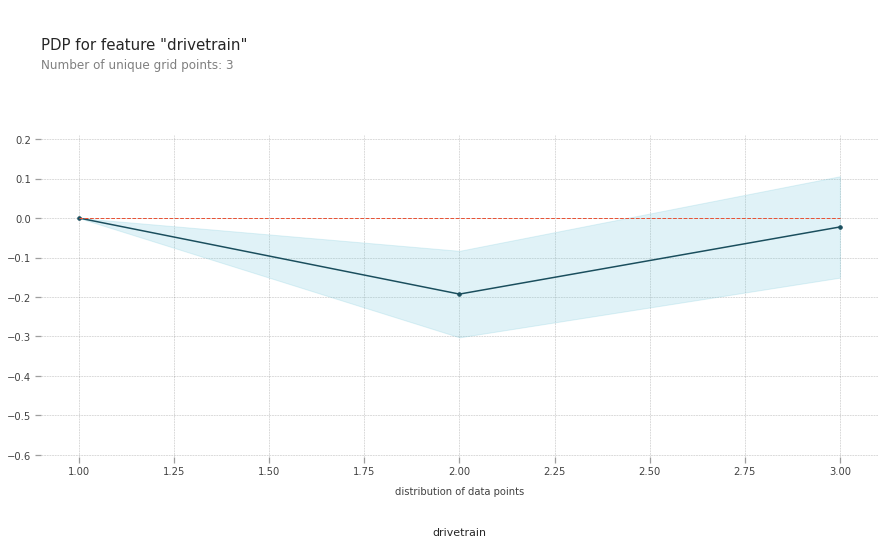

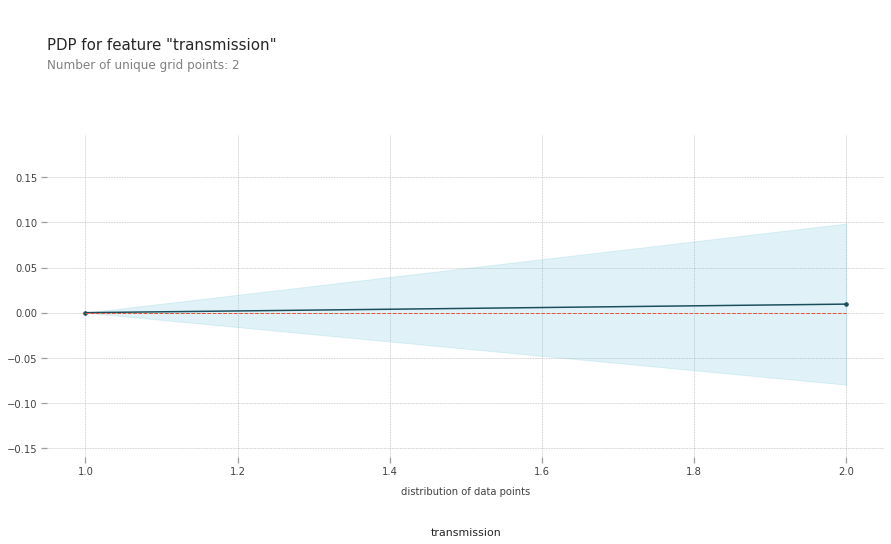

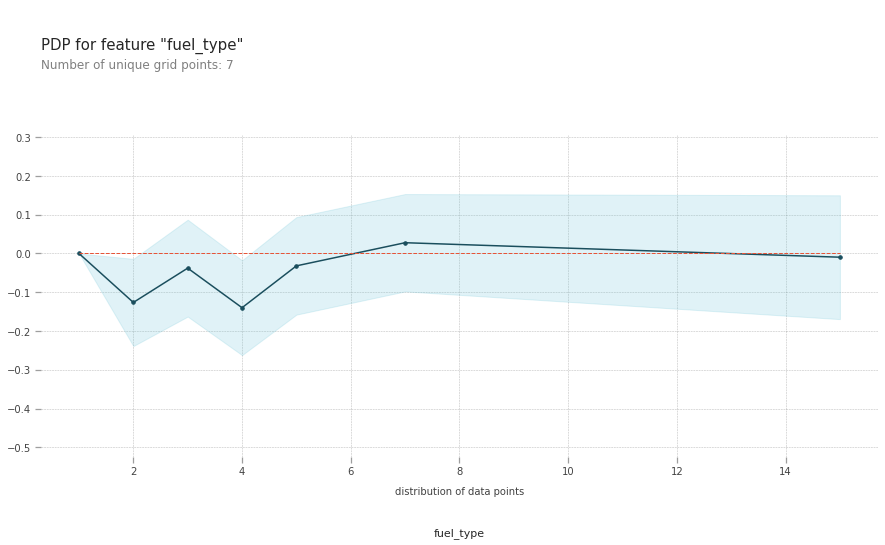

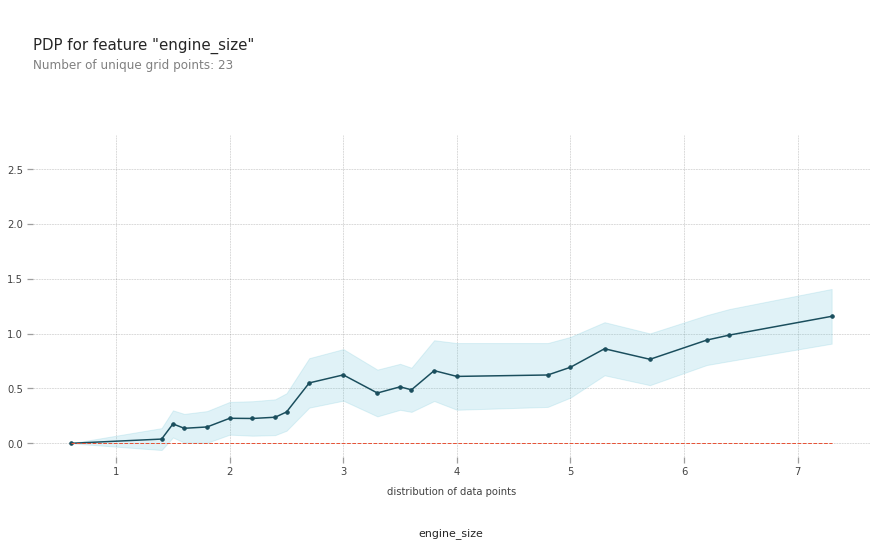

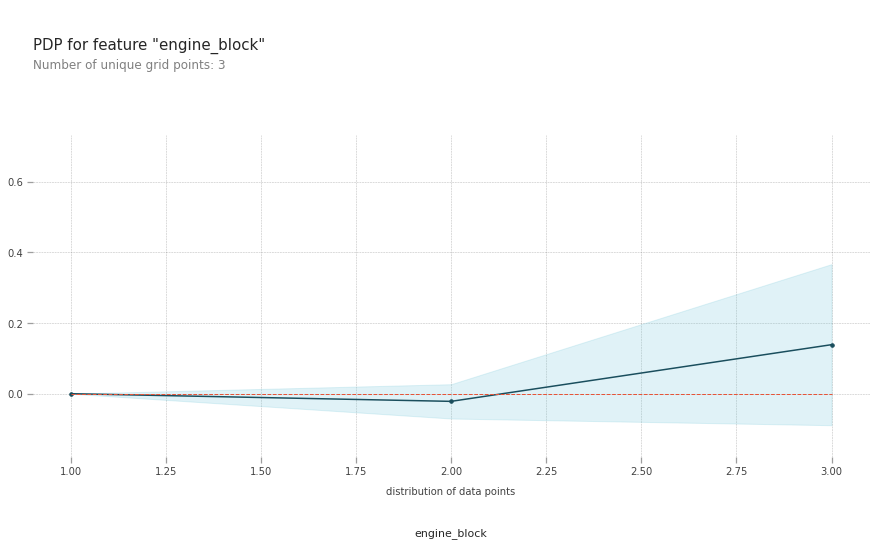

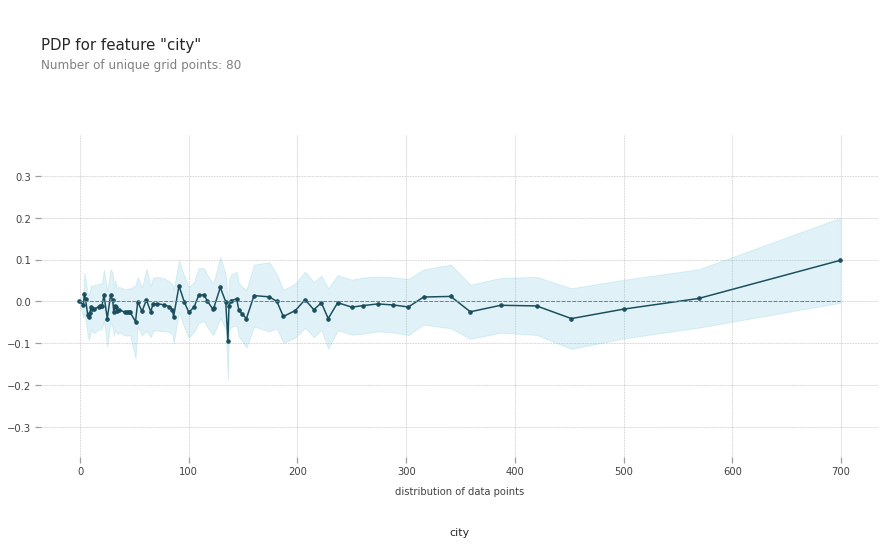

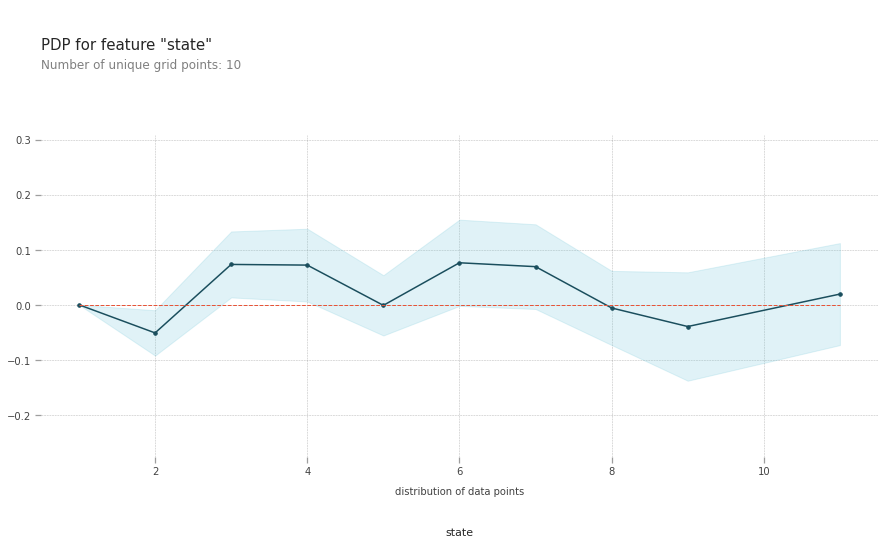

In [278]:
# 그래디언트 부스팅 모델의 특성별 타겟과의 상관관계 분석
from pdpbox.pdp import pdp_isolate, pdp_plot
for feature in X_val.columns:
  isolated = pdp_isolate(
      model=boosting, 
      dataset=X_val_encoded, 
      model_features=X_val.columns, 
      feature=feature,
      num_grid_points=100, # grid 포인트를 더 줄 수 있습니다. default = 10
  )
  pdp_plot(isolated, 
           feature_name=feature,
           frac_to_plot=0.001,
           plot_pts_dist=True
           );
  plt.xlim(20000, 150000);

In [279]:
# mile : 가격과 음의 상관관계
# year : 뚜렷한 양의 상관관계계
# make : encoding mapping 의 30번 이후로 약간의 가격 상승(럭셔리 메이커 영향)
# trim : 상관관계 없다
# body_type : 상관관계 없다
# vehicle_type :  car보다 truck이 가격이 높다
# drivetrain : FWD가 가격이 낮다다
# transmission : 상관관계 없다
# fuel_type : 상관관계 없다다
# engine_size : 클수록 비싸진다
# engin_block : H가 비싸다(럭셔리 메이커 영향향)
# city : 상관관계가 없다
# state : 상관관계 없다

In [280]:
encoder.mapping

[{'col': 'make', 'mapping': BMW               1
  Mitsubishi        2
  Mazda             3
  Ford              4
  INFINITI          5
  Hyundai           6
  Chevrolet         7
  Mercedes-Benz     8
  Chrysler          9
  Volkswagen       10
  GMC              11
  Porsche          12
  Jeep             13
  Nissan           14
  Toyota           15
  Kia              16
  Dodge            17
  Honda            18
  RAM              19
  Audi             20
  Buick            21
  Acura            22
  Lexus            23
  MINI             24
  Subaru           25
  FIAT             26
  Volvo            27
  Cadillac         28
  Land Rover       29
  Maserati         30
  Jaguar           31
  Lincoln          32
  smart            33
  McLaren          34
  KARMA            35
  Scion            36
  Alfa Romeo       37
  GENESIS          38
  Pontiac          39
  Ferrari          40
  Aston Martin     41
  Saturn           42
  Rolls-Royce      43
  Suzuki           44
  Bent

In [281]:
# encoder.mapping[8]['mapping'][(encoder.mapping[8]['mapping']==350) | (encoder.mapping[8]['mapping']>600)]

In [283]:
# Test Data 성능 측정 by XGBoost
X_test_encoded = encoder.transform(X_test)
y_pred = boosting.predict(X_test_encoded)
print('R^2', r2_score(y_test, y_pred))
print('mae', mean_absolute_error(y_test, y_pred))


R^2 0.9558887890057299
mae 0.08558132524109598


결론


1.    Make별 가격 분포를 살펴보면, 럭셔리카 Make를 제외하면 5만불을 넘지 않는다. 인기 있는 Make들은 주로 중간대(2.5만불)의 가격을 구성하는 것을 알 수 있어 인기 있는 Make의 경우, 평균적인 수준에서 가격을 결정하는 것이 합리적이다. 최적성능 ML모델, XGBoost의 경우, Make를 4번째 중요 인자로 본다. (year >> engine_size > miles > make)
2.   도시별 가격대의 큰 차이가 없는 것을 데이터 분포 확인을 통해서도 확인 할 수 있으며, ML모델분석하였을 때 역시, 도시는 가격대 결정에 두번째로 중요도가 떨어지는 인자임을 알 수 있다
3.   모델분석 결과, 감가요인으로 작용되는 year, miles 중 year가 훨신 중요도가 높았다. 당연한 결과이지만, 본 data가 8년간의 누적데이터여서 개별차량의 
   연령으로 환산하여 적용하는데는 한계가 있는 점을 감안해야 한다.(관련 사이트의 api설명 참조). 만악 데이터에 인터넷 등록일자가 추가된다면 
   훨씬 더 정교한 가격 산출이 가능할 것이다. 

